# Análisis de Resultados: Pruebas de Transmisión SDR

Realizado por: David Enriquez, Giuliano Frieri y Leonardo Lizcano


## Preparación

### Importar Librerías

In [197]:
import pandas as pd
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, wilcoxon, f_oneway, kruskal, levene, shapiro
from pingouin import welch_anova
from sklearn.linear_model import LinearRegression

### Cargar Datos

In [198]:
def load_csv(directory, name):
    df = pd.read_csv(f"{directory}{name}.csv")
    df['prueba'] = name
    return df

### Funciones de Análisis

#### Paquetes y Errores

In [199]:
def stats_paquetes(df):
    resumen = {}

    if 'mensaje' in df.columns:
        resumen['paquetes_totales'] = df['mensaje'].count()

    if 'crc_error' in df.columns:
        resumen['paquetes_ok'] = (df['crc_error'] == 0).sum()
        resumen['paquetes_err'] = (df['crc_error'] == 1).sum()
        resumen['crc_errors'] = df['crc_error'].sum()

    if 'previous_overflow_sum' in df.columns:
        resumen['overflow_sum'] = df['previous_overflow_sum'].sum()

    if resumen.get('paquetes_totales') and resumen.get('paquetes_ok') is not None:
        resumen['porcentaje_rx_ok'] = 100 * resumen['paquetes_ok'] / resumen['paquetes_totales']

    return pd.DataFrame([resumen])

#### Análisis Estadístico General

In [200]:
def describir_metricas(df):
    cols = df.select_dtypes(include=['number']).columns.tolist()
    return df[cols].describe()

#### Pruebas Estadísticas

In [201]:
def comparar_metricas_por_distancia(df, metrica, columna_grupo='prueba'):
    grupos = [grupo[metrica].dropna() for _, grupo in df.groupby(columna_grupo)]

    grupos = [g for g in grupos if len(g) > 0]
    if len(grupos) < 2:
        return {"metrica": metrica, "test": "Insuficiente", "p-valor": None}

    normal = all(shapiro(g)[1] > 0.05 for g in grupos)

    # Si hay normalidad
    if normal:
        _, p_levene = levene(*grupos)
        if p_levene > 0.05:
            # Varianzas homogéneas → ANOVA clásico
            stat, p = f_oneway(*grupos)
            test = "ANOVA"
        else:
            # Varianzas desiguales → Welch ANOVA
            resultado = welch_anova(data=df[[columna_grupo, metrica]].dropna(), dv=metrica, between=columna_grupo)
            stat = resultado["F"].iloc[0]
            p = resultado["p-unc"].iloc[0]
            test = "ANOVA de Welch"
    else:
        # No hay normalidad → Kruskal-Wallis
        stat, p = kruskal(*grupos)
        test = "Kruskal-Wallis"

    return {"metrica": metrica, "test": test, "p-valor": p}

#### Visualización de Resultados

In [202]:
#Histograma de las métricas
def plot_histograma(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No numeric columns found.")
        return

    fig, axes = plt.subplots(1, len(numeric_cols), figsize=(5 * len(numeric_cols), 4))

    if len(numeric_cols) == 1:
        axes = [axes]

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i])
        axes[i].set_title(f'Histograma: {col}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

#Diagrama de correlación de las métricas
def plot_correlacion(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No numeric columns found for correlation.")
        return

    corr = df[numeric_cols].corr()

    plt.figure(figsize=(1.2 * len(numeric_cols), 1.2 * len(numeric_cols)))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
    plt.title("Correlación entre métricas")
    plt.tight_layout()
    plt.show()
    
def plot_metricas_por_distancia(df, metricas, tipo='box', columna_grupo='prueba'):
    metricas_presentes = [m for m in metricas if m in df.columns]
    fig, axes = plt.subplots(1, len(metricas_presentes), figsize=(5 * len(metricas_presentes), 4))

    if len(metricas_presentes) == 1:
        axes = [axes]  # Asegurar que axes sea iterable

    for i, metrica in enumerate(metricas_presentes):
        if tipo == 'box':
            sns.boxplot(data=df, x=columna_grupo, y=metrica, ax=axes[i])
        elif tipo == 'hist':
            sns.histplot(data=df, x=metrica, hue=columna_grupo, ax=axes[i], kde=True, element="step", common_norm=False)
        axes[i].set_title(f'{metrica} por {columna_grupo}')
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


## Ejecución

### Prueba #1

#### Cargado de Datos

In [203]:
df_8M21M = load_csv("preprocessed_csv/merge/", "8M-21m")
df_8M50M = load_csv("preprocessed_csv/merge/", "8M-50m")

display(df_8M21M)
display(df_8M50M)

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,Giuliano 8MSPS:0,0,3.749480e-06,38.4686,-0.180415,1.047740,0,0,8M-21m
1,Giuliano 8MSPS:01,1,-4.944860e-07,103.9380,-0.162118,-2.477210,1,0,8M-21m
2,Giuliano 8MSPS:02,2,-5.659790e-07,14.9291,-0.180438,2.732200,0,0,8M-21m
3,�iudiano 8MSPS:03,3,1.785020e-06,66.2230,-0.178331,0.449194,1,0,8M-21m
4,Giuliano 8MSPS:06,6,-2.946630e-06,26.6316,-0.182944,3.960060,0,0,8M-21m
...,...,...,...,...,...,...,...,...,...
106,Giuliano 8MSPS:057,57,2.351720e-07,93.0293,-0.184805,0.443308,0,0,8M-21m
107,Giuliano 8MSPS:058,58,1.454880e-06,55.1818,-0.179641,1.936130,0,0,8M-21m
108,Giuliano 8MSPS:059,59,3.269460e-06,118.4090,-0.195724,2.363130,0,0,8M-21m
109,Giuliano 8MSPS:061,61,-7.096430e-07,42.9112,-0.168428,2.126810,0,0,8M-21m


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,mapuka�8MSPS:08,8,-4.355670e-07,65.94550,-0.165251,-11.61820,1,0,8M-50m
1,Mapuka 8MSPS:0,0,-1.929170e-07,42.97580,-0.191740,-1.57159,0,0,8M-50m
2,Mapuka 8MSPS:01,1,-1.195340e-05,3.50514,-1.185320,-2.28695,0,0,8M-50m
3,Mapuka 8MSPS:02,2,8.465100e-07,34.10570,-0.180297,-2.27101,0,0,8M-50m
4,Mapuka 8MSPS:03,3,-1.199890e-05,23.49940,-1.194550,-2.29249,0,0,8M-50m
...,...,...,...,...,...,...,...,...,...
108,Mapuka 8MSPS:055,55,-2.410470e-06,21.69860,-0.185351,-2.08369,0,0,8M-50m
109,Mapuka 8MSPS:056,56,-2.484940e-07,100.96900,-0.174419,-1.05066,0,0,8M-50m
110,Mapuka 8MSPS:057,57,-1.167940e-05,17.53940,-1.189740,-3.49105,0,0,8M-50m
111,Mapuka 8MSPS:058,58,1.600550e-06,71.20000,-0.185304,-2.86233,0,0,8M-50m


#### Paquetes y Errores

In [204]:
stats_packs_8M21M = stats_paquetes(df_8M21M)
stats_packs_8M50M = stats_paquetes(df_8M50M)

display(stats_packs_8M21M)
display(stats_packs_8M50M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,111,103,8,8,18,92.792793


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,113,110,3,3,0,97.345133


#### Análisis Estadístico General

In [205]:
describir_metricas_8M21M = describir_metricas(df_8M21M)
describir_metricas_8M50M = describir_metricas(df_8M50M)

display(describir_metricas_8M21M)
display(describir_metricas_8M50M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,111.000000,1.110000e+02,111.000000,111.000000,111.000000,111.000000,111.000000
mean,28.423423,-9.282714e-09,62.746466,-0.183211,1.639292,0.072072,0.162162
std,17.346495,2.303975e-06,36.159120,0.010535,3.005236,0.259780,1.708484
min,-1.000000,-3.898120e-06,0.740601,-0.218379,-13.321700,0.000000,0.000000
25%,14.000000,-1.948890e-06,32.125800,-0.190240,0.527157,0.000000,0.000000
50%,28.000000,-1.437670e-07,62.363400,-0.182677,2.059260,0.000000,0.000000
75%,43.000000,1.938985e-06,93.686150,-0.176365,3.585710,0.000000,0.000000
max,62.000000,3.981860e-06,123.784000,-0.153728,6.007770,1.000000,18.000000


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,113.000000,1.130000e+02,113.000000,113.000000,113.000000,113.000000,113.0
mean,27.345133,-9.370387e-07,54.086269,-0.277844,-3.419466,0.026549,0.0
std,16.913525,3.899645e-06,35.248578,0.286900,2.567872,0.161476,0.0
min,-1.000000,-1.199890e-05,-0.281247,-1.212630,-11.618200,0.000000,0.0
25%,13.000000,-2.410470e-06,26.843900,-0.197786,-4.944280,0.000000,0.0
50%,27.000000,-3.004090e-07,46.010600,-0.189856,-3.153940,0.000000,0.0
75%,41.000000,1.525650e-06,78.556900,-0.182331,-1.478880,0.000000,0.0
max,59.000000,3.983370e-06,127.076000,-0.155541,1.818130,1.000000,0.0


#### Visualización de Resultados

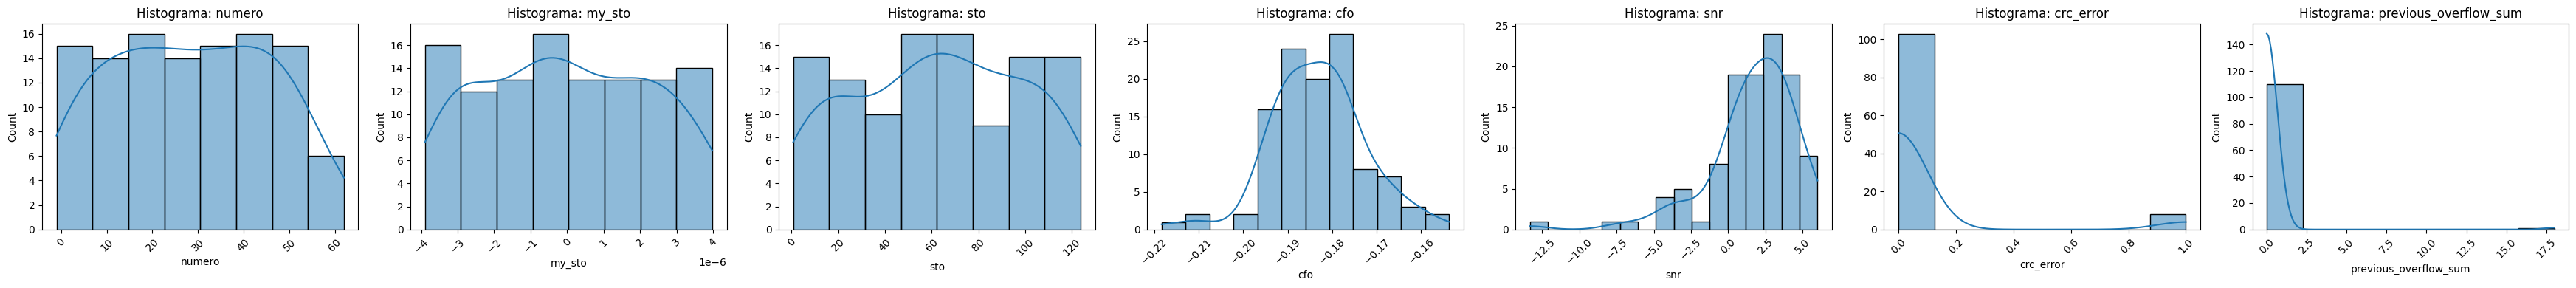

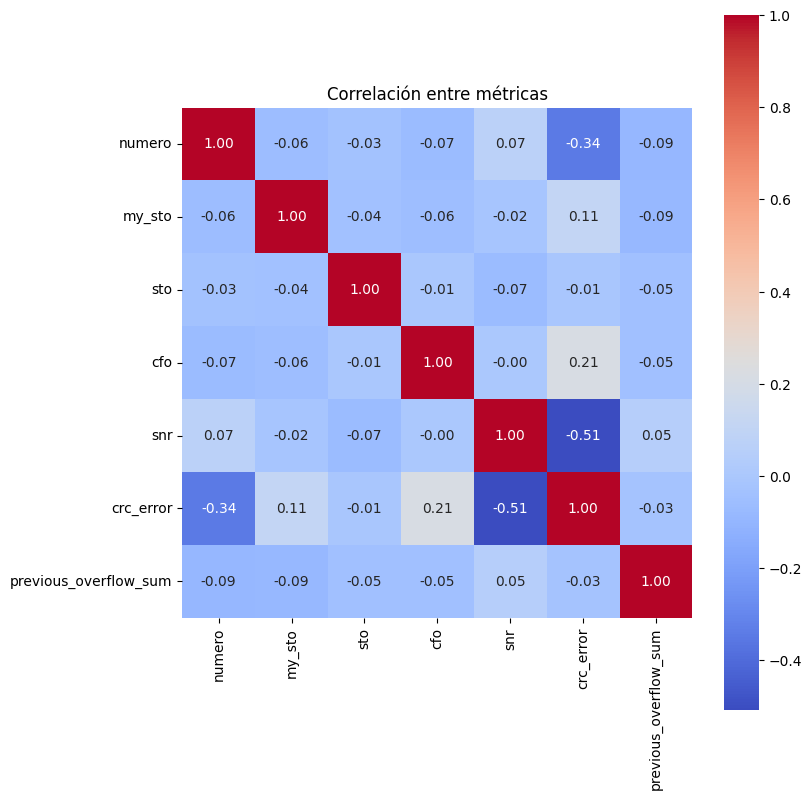

In [206]:
plot_histograma(df_8M21M)
plot_correlacion(df_8M21M)

In [ ]:
plot_histograma(df_8M50M)
plot_correlacion(df_8M50M)

### Prueba #2

#### Cargado de Datos

In [ ]:
#PRUEBAS A 1M DE DISTANCIA
df_4M1M = load_csv("03-04-2025_csv/", "4M-1m-1")
df_8M1M = load_csv("03-04-2025_csv/", "8M-1m-1")
df_N_4M1M = load_csv("Neisser_03-04-2025_csv/", "1m4msps")
df_N_8M1M = load_csv("Neisser_03-04-2025_csv/", "1m8msps")

display(df_4M1M.head())
display(df_8M1M.head())
display(df_N_4M1M.head())
display(df_N_8M1M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,1M 4MSPS:0,0,5.400320e-07,48.0674,-0.177525,20.6317,0,0,4M-1m-1
1,1M 4MSPS:01,1,1.019250e-06,59.1273,-0.180525,18.9488,0,0,4M-1m-1
2,1M 4MSPS:02,2,2.484900e-06,57.3105,-0.185939,20.3911,0,0,4M-1m-1
3,1M 4MSPS:03,3,1.044650e-06,19.1305,-0.179333,20.4081,0,0,4M-1m-1
4,1M 4MSPS:04,4,1.820470e-06,123.2270,-0.182460,20.0183,0,0,4M-1m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,1M 8MSPS:0,0,2.799170e-07,58.0349,-0.182969,20.2908,0,0,8M-1m-1
1,1M 8MSPS:01,1,1.550390e-06,89.1937,-0.184022,20.3064,0,0,8M-1m-1
2,1M 8MSPS:02,2,4.983300e-07,46.0622,-0.179368,20.6883,0,0,8M-1m-1
3,1M 8MSPS:03,3,-2.999620e-06,105.6250,-0.198564,13.2632,0,0,8M-1m-1
4,1M 8MSPS:04,4,2.950420e-06,6.3687,-0.184068,20.2472,0,0,8M-1m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,1M 4MSPS:0,0,-35,10.75,10,1m4msps
1,1M 4MSPS:01,1,-31,10.75,11,1m4msps
2,1M 4MSPS:02,2,-30,11.50,11,1m4msps
3,1M 4MSPS:03,3,-30,11.25,11,1m4msps
4,1M 4MSPS:04,4,-30,11.25,11,1m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,1M 8MSPS:0,0,-35,11.00,10,1m8msps
1,1M 8MSPS:01,1,-30,11.75,11,1m8msps
2,1M 8MSPS:02,2,-31,10.75,11,1m8msps
3,1M 8MSPS:03,3,-30,12.00,11,1m8msps
4,1M 8MSPS:04,4,-30,11.75,11,1m8msps


In [ ]:
#PRUEBAS A 40M DE DISTANCIA
df_4M40M = load_csv("03-04-2025_csv/", "4M-40m-1")
df_8M40M = load_csv("03-04-2025_csv/", "8M-40m-1")
df_N_4M40M = load_csv("Neisser_03-04-2025_csv/", "40m4msps")
df_N_8M40M = load_csv("Neisser_03-04-2025_csv/", "40m8msps")

display(df_4M40M.head())
display(df_8M40M.head())
display(df_N_4M40M.head())
display(df_N_8M40M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,40M 4MSPS:0,0,4.309830e-07,40.0538,-0.176547,20.0248,0,0,4M-40m-1
1,40M 4MSPS:01,1,-1.902220e-06,40.7621,-0.174969,20.3771,0,0,4M-40m-1
2,40M 4MSPS:02,2,1.886170e-07,36.0235,-0.180400,20.4179,0,0,4M-40m-1
3,40M 4MSPS:03,3,-9.543910e-07,94.8806,-0.177438,20.4732,0,0,4M-40m-1
4,40M 4MSPS:04,4,1.617200e-06,88.2020,-0.185021,19.7842,0,0,4M-40m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,40M 8MSPS:0,0,1.223950e-06,109.1530,-0.181409,19.7983,0,0,8M-40m-1
1,40M 8MSPS:01,1,1.374560e-06,22.1717,-0.183081,19.9153,0,0,8M-40m-1
2,40M 8MSPS:02,2,9.930730e-07,35.1240,-0.182375,20.1746,0,0,8M-40m-1
3,40M 8MSPS:03,3,3.991100e-06,115.4990,-0.190732,20.0077,0,1,8M-40m-1
4,40M 8MSPS:04,4,2.715640e-06,114.3390,-0.189435,20.0185,0,0,8M-40m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,40M 4MSPS:0,0,-71,11.00,11,40m4msps
1,40M 4MSPS:01,1,-76,10.75,12,40m4msps
2,40M 4MSPS:02,2,-73,10.50,12,40m4msps
3,40M 4MSPS:03,3,-72,10.50,12,40m4msps
4,40M 4MSPS:04,4,-72,10.00,12,40m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,40M 8MSPS:0,0,-70,10.50,11,40m8msps
1,40M 8MSPS:01,1,-71,10.25,12,40m8msps
2,40M 8MSPS:02,2,-71,10.50,12,40m8msps
3,40M 8MSPS:03,3,-72,10.25,12,40m8msps
4,40M 8MSPS:04,4,-70,11.00,12,40m8msps


In [ ]:
#PRUEBAS A 80M DE DISTANCIA
df_4M80M = load_csv("03-04-2025_csv/", "4M-80m-1")
df_8M80M = load_csv("03-04-2025_csv/", "8M-80m-1")
df_N_4M80M = load_csv("Neisser_03-04-2025_csv/", "80m4msps")
df_N_8M80M = load_csv("Neisser_03-04-2025_csv/", "80m8msps")

display(df_4M80M.head())
display(df_8M80M.head())
display(df_N_4M80M.head())
display(df_N_8M80M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,80M 4MSPS:0,0,1.547260e-06,88.19330,-0.185440,10.291800,0,0,4M-80m-1
1,80M 4MSPS:01,1,1.754640e-06,52.21920,-0.179992,9.163980,0,0,4M-80m-1
2,80M 4MSPS:02,2,-1.774910e-06,44.77800,-0.180113,2.684410,0,0,4M-80m-1
3,80M 4MSPS:03,3,2.926780e-06,7.36574,-0.179554,0.946018,0,0,4M-80m-1
4,80M 4MSPS:04,4,-2.042420e-07,111.97400,-0.172717,8.031180,0,0,4M-80m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,80M 8MSPS:0,0,2.223310e-06,95.2778,-0.191848,7.992830,0,0,8M-80m-1
1,80M 8MSPS:01,1,-2.306760e-06,79.7116,-0.165455,2.763030,0,0,8M-80m-1
2,80M 8MSPS:02,2,-1.185590e-06,37.8517,-0.175385,-4.431020,0,0,8M-80m-1
3,80M 8MSPS:03,3,3.476260e-06,30.4344,-0.189023,-0.274857,0,0,8M-80m-1
4,80M 8MSPS:04,4,2.429480e-08,60.0029,-0.179658,1.650910,0,0,8M-80m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,80M 4MSPS:0,0,-89,10.25,11,80m4msps
1,80M 4MSPS:01,1,-86,10.25,12,80m4msps
2,80M 4MSPS:02,2,-86,11.25,12,80m4msps
3,80M 4MSPS:03,3,-91,10.25,12,80m4msps
4,80M 4MSPS:04,4,-94,9.50,12,80m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,80M 8MSPS:0,0,-89,10.25,11,80m8msps
1,80M 8MSPS:02,2,-81,10.25,12,80m8msps
2,80M 8MSPS:03,3,-85,10.50,12,80m8msps
3,80M 8MSPS:04,4,-85,10.75,12,80m8msps
4,80M 8MSPS:05,5,-87,10.50,12,80m8msps


In [ ]:
#PRUEBAS A 120M DE DISTANCIA
df_4M120M = load_csv("03-04-2025_csv/", "4M-120m-1")
df_8M120M = load_csv("03-04-2025_csv/", "8M-120m-1")
df_N_4M120M = load_csv("Neisser_03-04-2025_csv/", "120m4msps")
df_N_8M120M = load_csv("Neisser_03-04-2025_csv/", "120m8msps")

display(df_4M120M.head())
display(df_8M120M.head())
display(df_N_4M120M.head())
display(df_N_8M120M.head())

,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,120M 4MSPS:0,0,-1.492480e-06,18.8133,-0.187503,5.85431,0,0,4M-120m-1
1,120M 4MSPS:01,1,-8.751470e-07,24.8905,-0.180793,6.85774,0,0,4M-120m-1
2,120M 4MSPS:02,2,6.168400e-08,74.0076,-0.173580,10.82400,0,0,4M-120m-1
3,120M 4MSPS:03,3,-3.781950e-06,61.5271,-0.187681,5.04012,0,0,4M-120m-1
4,120M 4MSPS:04,4,1.517520e-06,127.1900,-0.185270,8.69377,0,0,4M-120m-1


,mensaje,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum,prueba
0,120M 8MSPS:0,0,0.000003,39.4076,-0.190737,4.40790,0,0,8M-120m-1
1,120M 8MSPS:01,1,0.000001,123.1450,-0.186781,3.27971,0,0,8M-120m-1
2,120M 8MSPS:02,2,-0.000002,114.6910,-0.190783,5.85015,0,0,8M-120m-1
3,120M 8MSPS:03,3,0.000001,108.1860,-0.182912,8.33454,0,0,8M-120m-1
4,120M 8MSPS:04,4,0.000002,75.2722,-0.184297,8.85283,0,0,8M-120m-1


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,120M 4MSPS:0,0,-85,10.00,12,120m4msps
1,120M 4MSPS:01,1,-82,11.00,13,120m4msps
2,120M 4MSPS:02,2,-81,11.50,13,120m4msps
3,120M 4MSPS:04,4,-83,11.00,13,120m4msps
4,120M 4MSPS:05,5,-84,11.75,13,120m4msps


,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,120M 8MSPS:0,0,-85,10.00,12,120m8msps
1,120M 8MSPS:01,1,-86,11.25,13,120m8msps
2,120M 8MSPS:02,2,-85,11.25,13,120m8msps
3,120M 8MSPS:03,3,-83,11.75,13,120m8msps
4,120M 8MSPS:04,4,-84,11.50,13,120m8msps


#### Paquetes y Errores

In [ ]:
stats_packs_4M1M = stats_paquetes(df_4M1M)
stats_packs_8M1M = stats_paquetes(df_8M1M)
stats_packs_N_4M1M = stats_paquetes(df_N_4M1M)
stats_packs_N_8M1M = stats_paquetes(df_N_8M1M)


display(stats_packs_4M1M)
display(stats_packs_8M1M)
display(stats_packs_N_4M1M)
display(stats_packs_N_8M1M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,102,102,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,103,103,0,0,4,100.0


,paquetes_totales
0,100


,paquetes_totales
0,49


In [ ]:
stats_packs_4M40M = stats_paquetes(df_4M40M)
stats_packs_8M40M = stats_paquetes(df_8M40M)
stats_packs_N_4M40M = stats_paquetes(df_N_4M40M)
stats_packs_N_8M40M = stats_paquetes(df_N_8M40M)

display(stats_packs_4M40M)
display(stats_packs_8M40M)
display(stats_packs_N_4M40M)
display(stats_packs_N_8M40M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,103,103,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,103,103,0,0,18,100.0


,paquetes_totales
0,97


,paquetes_totales
0,103


In [ ]:
stats_packs_4M80M = stats_paquetes(df_4M80M)
stats_packs_8M80M = stats_paquetes(df_8M80M)
stats_packs_N_4M80M = stats_paquetes(df_N_4M80M)
stats_packs_N_8M80M = stats_paquetes(df_N_8M80M)

display(stats_packs_4M80M)
display(stats_packs_8M80M)
display(stats_packs_N_4M80M)
display(stats_packs_N_8M80M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,102,102,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,102,100,2,2,25,98.039216


,paquetes_totales
0,96


,paquetes_totales
0,102


In [ ]:
stats_packs_4M120M = stats_paquetes(df_4M120M)
stats_packs_8M120M = stats_paquetes(df_8M120M)
stats_packs_N_4M120M = stats_paquetes(df_N_4M120M)
stats_packs_N_8M120M = stats_paquetes(df_N_8M120M)

display(stats_packs_4M120M)
display(stats_packs_8M120M)
display(stats_packs_N_4M120M)
display(stats_packs_N_8M120M)

,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,103,103,0,0,0,100.0


,paquetes_totales,paquetes_ok,paquetes_err,crc_errors,overflow_sum,porcentaje_rx_ok
0,103,103,0,0,3,100.0


,paquetes_totales
0,101


,paquetes_totales
0,104


#### Análisis Estadístico General

In [ ]:
describir_metricas_4M1M = describir_metricas(df_4M1M)
describir_metricas_8M1M = describir_metricas(df_8M1M)
describir_metricas_N_4M1M = describir_metricas(df_N_4M1M)
describir_metricas_N_8M1M = describir_metricas(df_N_8M1M)

display(describir_metricas_4M1M)
display(describir_metricas_8M1M)
display(describir_metricas_N_4M1M)
display(describir_metricas_N_8M1M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.0,102.0
mean,50.500000,-7.497344e-07,64.396364,-0.241596,19.601587,0.0,0.0
std,29.588849,3.397158e-06,37.669461,0.238731,2.030088,0.0,0.0
min,0.000000,-1.186260e-05,0.033938,-1.194530,8.043560,0.0,0.0
25%,25.250000,-2.211435e-06,37.762625,-0.188236,19.690300,0.0,0.0
50%,50.500000,-2.685670e-07,61.966100,-0.182583,20.202900,0.0,0.0
75%,75.750000,1.593070e-06,92.603700,-0.176795,20.423825,0.0,0.0
max,101.000000,3.925730e-06,126.468000,-0.169425,20.681800,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.0,103.000000
mean,51.000000,-3.087403e-08,67.306712,-0.200284,20.156056,0.0,0.038835
std,29.877528,2.825574e-06,36.386956,0.139031,0.864143,0.0,0.194146
min,0.000000,-1.191200e-05,-0.063382,-1.186830,13.263200,0.0,0.000000
25%,25.500000,-2.349280e-06,37.346100,-0.186835,20.203350,0.0,0.000000
50%,51.000000,7.229050e-07,66.263100,-0.181075,20.327800,0.0,0.000000
75%,76.500000,2.139975e-06,104.218000,-0.176694,20.436250,0.0,0.000000
max,102.000000,3.874470e-06,127.316000,-0.162615,20.688300,0.0,1.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,100.000000,100.000000,100.000000,100.000000
mean,51.070000,-31.400000,10.732500,11.930000
std,30.436971,1.556998,0.500322,0.408372
min,0.000000,-37.000000,10.000000,10.000000
25%,24.750000,-31.000000,10.500000,12.000000
50%,51.500000,-31.000000,10.750000,12.000000
75%,77.250000,-31.000000,11.000000,12.000000
max,103.000000,-29.000000,13.250000,13.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,49.000000,49.00000,49.000000,49.000000
mean,24.183673,-31.44898,10.811224,11.775510
std,14.554028,1.78023,0.434605,0.468388
min,0.000000,-38.00000,9.750000,10.000000
25%,12.000000,-32.00000,10.500000,12.000000
50%,24.000000,-31.00000,10.750000,12.000000
75%,36.000000,-31.00000,11.000000,12.000000
max,49.000000,-29.00000,12.000000,12.000000


In [ ]:
describir_metricas_4M40M = describir_metricas(df_4M40M)
describir_metricas_8M40M = describir_metricas(df_8M40M)
describir_metricas_N_4M40M = describir_metricas(df_N_4M40M)
describir_metricas_N_8M40M = describir_metricas(df_N_8M40M)

display(describir_metricas_4M40M)
display(describir_metricas_8M40M)
display(describir_metricas_N_4M40M)
display(describir_metricas_N_8M40M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.0,103.0
mean,51.000000,-3.760323e-07,62.273245,-0.231097,20.072473,0.0,0.0
std,29.877528,3.411557e-06,36.659300,0.217196,1.020430,0.0,0.0
min,0.000000,-1.162060e-05,0.499587,-1.194510,14.127000,0.0,0.0
25%,25.500000,-2.415090e-06,36.144000,-0.188439,20.079350,0.0,0.0
50%,51.000000,1.524630e-07,62.870200,-0.183174,20.262200,0.0,0.0
75%,76.500000,2.153830e-06,92.362450,-0.177818,20.423850,0.0,0.0
max,102.000000,3.997550e-06,127.365000,-0.166959,20.591900,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.0,103.000000
mean,51.000000,2.862633e-08,57.430642,-0.223774,19.987745,0.0,0.174757
std,29.877528,3.109979e-06,39.120505,0.195282,0.625648,0.0,0.406496
min,0.000000,-1.180500e-05,0.076218,-1.196430,15.912600,0.0,0.000000
25%,25.500000,-1.337920e-06,24.224100,-0.189503,20.015400,0.0,0.000000
50%,51.000000,6.786160e-07,48.982200,-0.185024,20.111300,0.0,0.000000
75%,76.500000,2.302050e-06,92.821750,-0.180887,20.180650,0.0,0.000000
max,102.000000,3.991100e-06,127.094000,-0.171521,20.376300,0.0,2.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,97.000000,97.000000,97.000000,97.000000
mean,51.618557,-70.927835,11.056701,12.917526
std,30.507664,1.542775,0.483457,0.399742
min,0.000000,-78.000000,10.000000,11.000000
25%,25.000000,-72.000000,10.750000,13.000000
50%,53.000000,-71.000000,11.000000,13.000000
75%,78.000000,-70.000000,11.250000,13.000000
max,102.000000,-68.000000,13.500000,14.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,103.000000,103.000000,103.000000,103.000000
mean,54.349515,-70.796117,11.230583,12.961165
std,30.815615,1.497444,0.586500,0.441084
min,0.000000,-75.000000,10.250000,11.000000
25%,29.500000,-72.000000,10.750000,13.000000
50%,55.000000,-71.000000,11.250000,13.000000
75%,80.500000,-70.000000,11.500000,13.000000
max,106.000000,-68.000000,14.500000,14.000000


In [ ]:
describir_metricas_4M80M = describir_metricas(df_4M80M)
describir_metricas_8M80M = describir_metricas(df_8M80M)
describir_metricas_N_4M80M = describir_metricas(df_N_4M80M)
describir_metricas_N_8M80M = describir_metricas(df_N_8M80M)

display(describir_metricas_4M80M)
display(describir_metricas_8M80M)
display(describir_metricas_N_4M80M)
display(describir_metricas_N_8M80M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.0,102.0
mean,50.676471,-3.832458e-07,65.481387,-0.196051,5.404039,0.0,0.0
std,29.843208,2.555589e-06,35.624703,0.140744,4.010015,0.0,0.0
min,0.000000,-1.107170e-05,-0.083738,-1.184740,-6.820570,0.0,0.0
25%,25.250000,-1.992110e-06,43.645725,-0.181834,2.737347,0.0,0.0
50%,50.500000,-3.727770e-07,65.000700,-0.176667,6.060815,0.0,0.0
75%,75.750000,1.443320e-06,93.926675,-0.171946,8.546520,0.0,0.0
max,102.000000,3.855640e-06,127.175000,-0.155343,12.135000,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.000000,102.000000
mean,51.029412,-1.129657e-07,58.289707,-0.201396,2.035361,0.019608,0.245098
std,30.543414,2.724466e-06,34.677064,0.140057,3.870957,0.139333,0.496249
min,-1.000000,-1.190240e-05,0.025350,-1.191340,-9.317990,0.000000,0.000000
25%,25.250000,-1.922980e-06,28.315650,-0.186920,0.174168,0.000000,0.000000
50%,50.500000,2.509520e-08,60.547250,-0.182366,2.112245,0.000000,0.000000
75%,76.750000,2.191320e-06,88.696900,-0.176954,5.039758,0.000000,0.000000
max,103.000000,3.923130e-06,123.701000,-0.161987,9.039140,1.000000,2.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,96.000000,96.000000,96.00000,96.000000
mean,51.989583,-86.812500,11.00000,12.947917
std,31.003054,3.985005,0.89883,0.444138
min,0.000000,-100.000000,6.50000,11.000000
25%,25.750000,-89.000000,10.75000,13.000000
50%,51.500000,-86.000000,11.00000,13.000000
75%,79.250000,-84.000000,11.50000,13.000000
max,105.000000,-80.000000,14.75000,14.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,102.000000,102.000000,102.000000,102.000000
mean,52.549020,-86.294118,11.041667,12.950980
std,30.463621,4.123318,0.768407,0.407296
min,0.000000,-97.000000,8.250000,11.000000
25%,26.250000,-88.750000,10.562500,13.000000
50%,52.500000,-85.000000,11.000000,13.000000
75%,78.750000,-83.250000,11.500000,13.000000
max,104.000000,-80.000000,13.250000,14.000000


In [ ]:
describir_metricas_4M120M = describir_metricas(df_4M120M)
describir_metricas_8M120M = describir_metricas(df_8M120M)
describir_metricas_N_4M120M = describir_metricas(df_N_4M120M)
describir_metricas_N_8M120M = describir_metricas(df_N_8M120M)

display(describir_metricas_4M120M)
display(describir_metricas_8M120M)
display(describir_metricas_N_4M120M)
display(describir_metricas_N_8M120M)

,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.0,103.0
mean,51.000000,-1.512216e-07,68.835354,-0.222507,9.219759,0.0,0.0
std,29.877528,3.181062e-06,36.636383,0.195348,1.765796,0.0,0.0
min,0.000000,-1.184770e-05,2.054490,-1.195140,2.617640,0.0,0.0
25%,25.500000,-2.097230e-06,37.529950,-0.188341,8.302430,0.0,0.0
50%,51.000000,3.402110e-07,68.310000,-0.184053,9.507780,0.0,0.0
75%,76.500000,1.881005e-06,98.667300,-0.179430,10.489550,0.0,0.0
max,102.000000,3.864090e-06,127.190000,-0.164596,12.470000,0.0,0.0


,numero,my_sto,sto,cfo,snr,crc_error,previous_overflow_sum
count,103.000000,1.030000e+02,103.000000,103.000000,103.000000,103.0,103.000000
mean,51.000000,-5.599797e-07,64.366780,-0.235990,5.987247,0.0,0.029126
std,29.877528,3.359661e-06,35.480441,0.215927,2.000552,0.0,0.168983
min,0.000000,-1.177440e-05,-0.170591,-1.189670,-1.765210,0.0,0.000000
25%,25.500000,-2.473240e-06,38.935500,-0.194523,5.207685,0.0,0.000000
50%,51.000000,-1.625570e-07,68.237700,-0.188611,6.498560,0.0,0.000000
75%,76.500000,1.753945e-06,89.318550,-0.183132,7.212755,0.0,0.000000
max,102.000000,3.932720e-06,126.270000,-0.164739,9.193800,0.0,1.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,101.000000,101.000000,101.000000,101.000000
mean,53.594059,-84.059406,11.091584,13.960396
std,29.917279,1.247572,0.407312,0.398015
min,0.000000,-87.000000,10.000000,12.000000
25%,29.000000,-85.000000,10.750000,14.000000
50%,54.000000,-84.000000,11.000000,14.000000
75%,79.000000,-83.000000,11.500000,14.000000
max,104.000000,-81.000000,12.000000,15.000000


,numero,rssi (dBm),snr (dB),size (bytes)
count,104.000000,104.000000,104.000000,104.000000
mean,52.000000,-84.182692,11.173077,13.942308
std,30.602367,1.512180,0.489051,0.414001
min,0.000000,-88.000000,10.000000,12.000000
25%,25.750000,-85.000000,10.750000,14.000000
50%,52.000000,-84.000000,11.250000,14.000000
75%,78.250000,-83.000000,11.500000,14.000000
max,104.000000,-81.000000,13.250000,15.000000


#### Visualización de Resultados

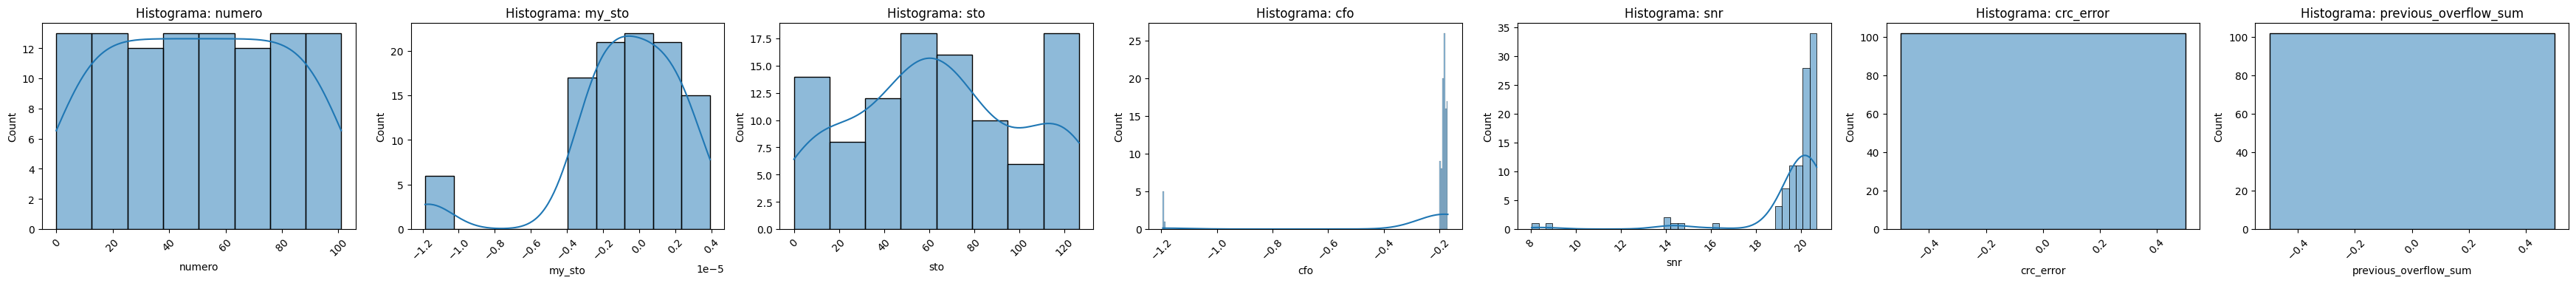

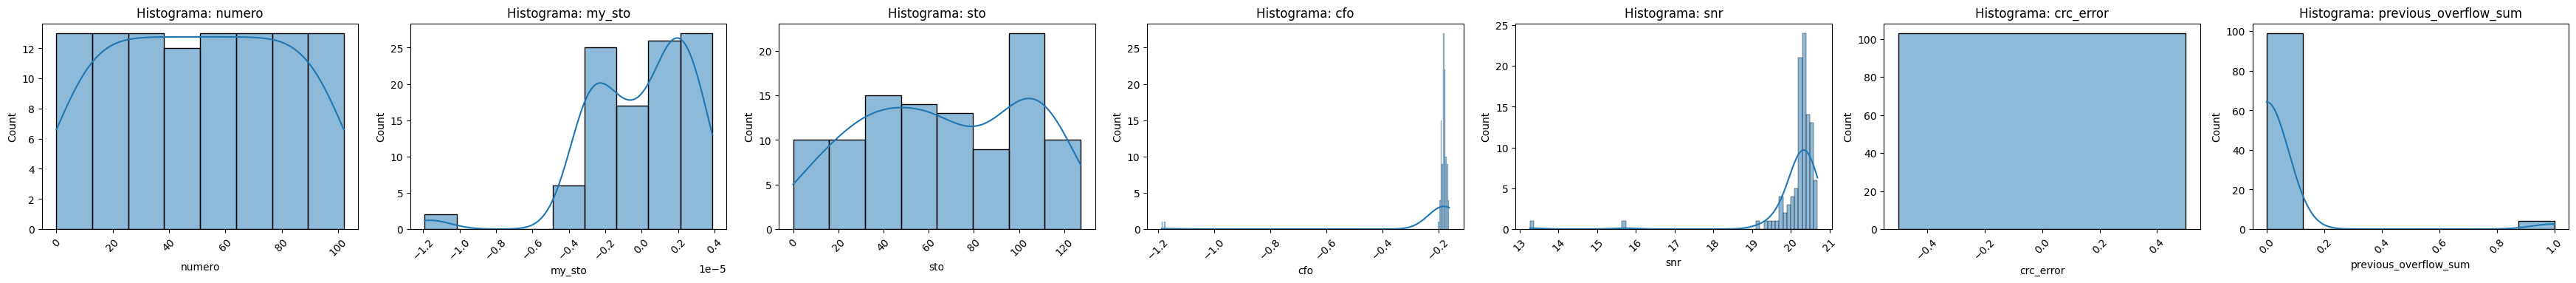

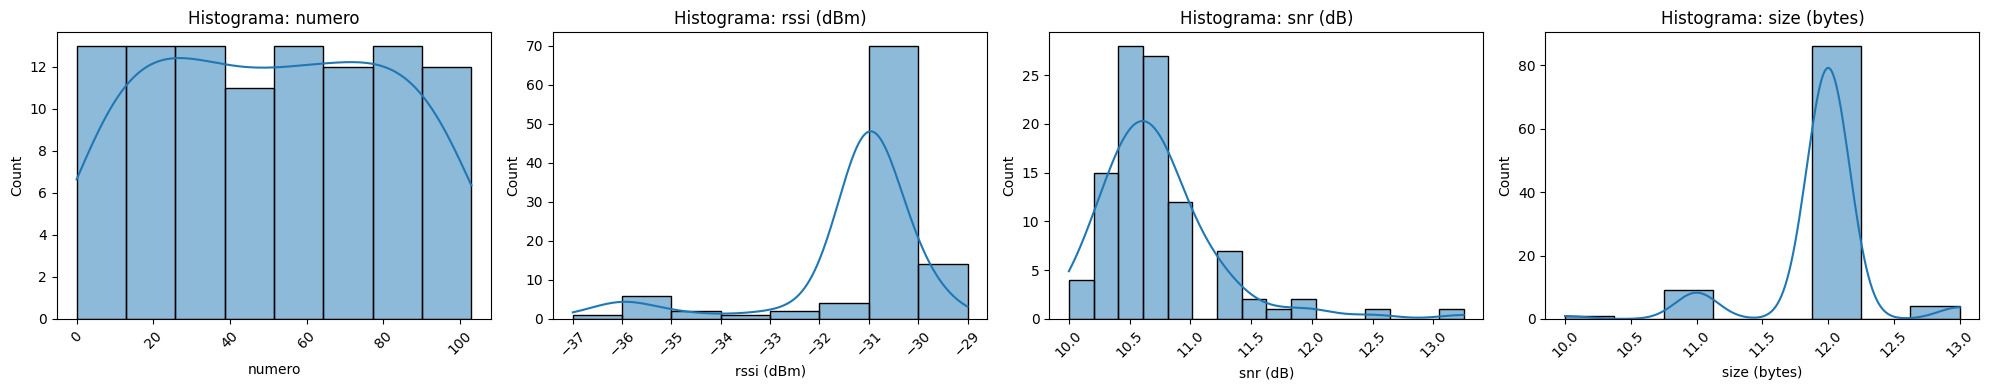

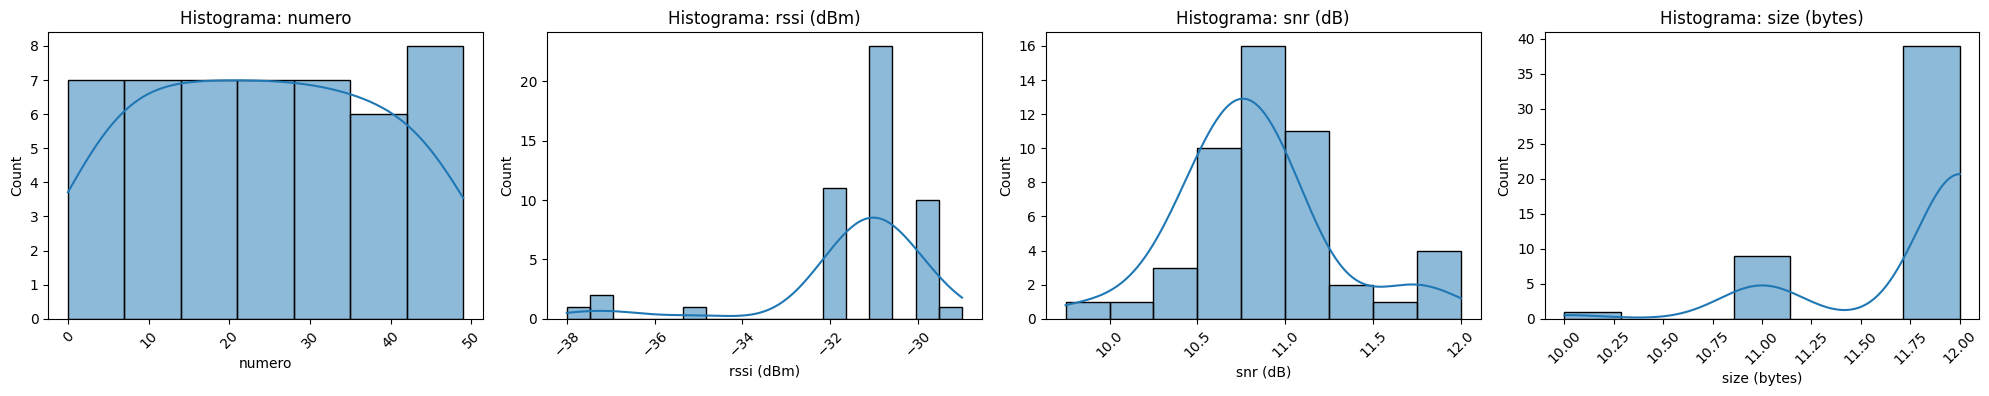

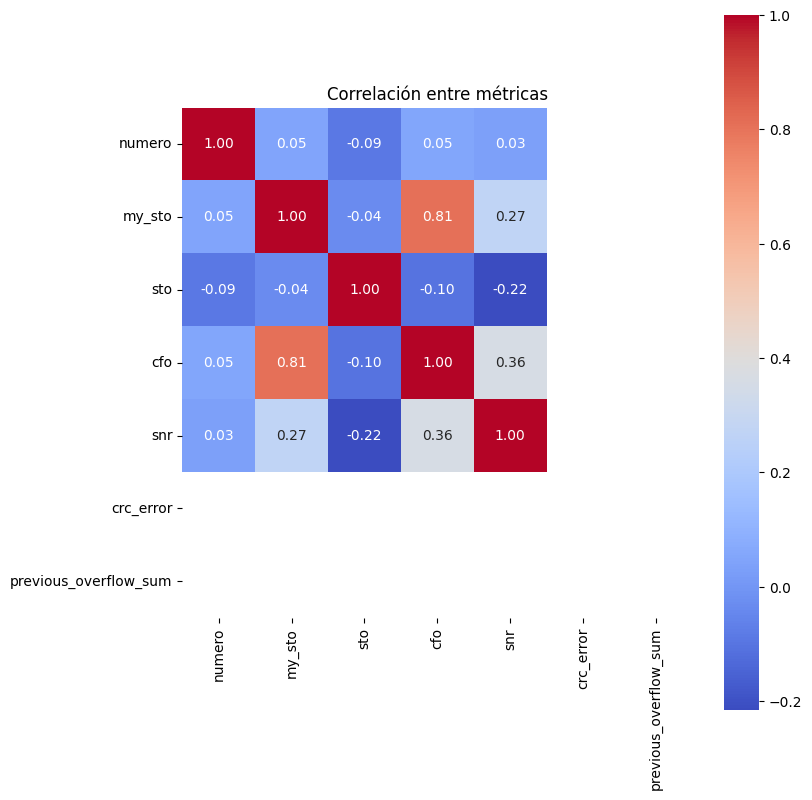

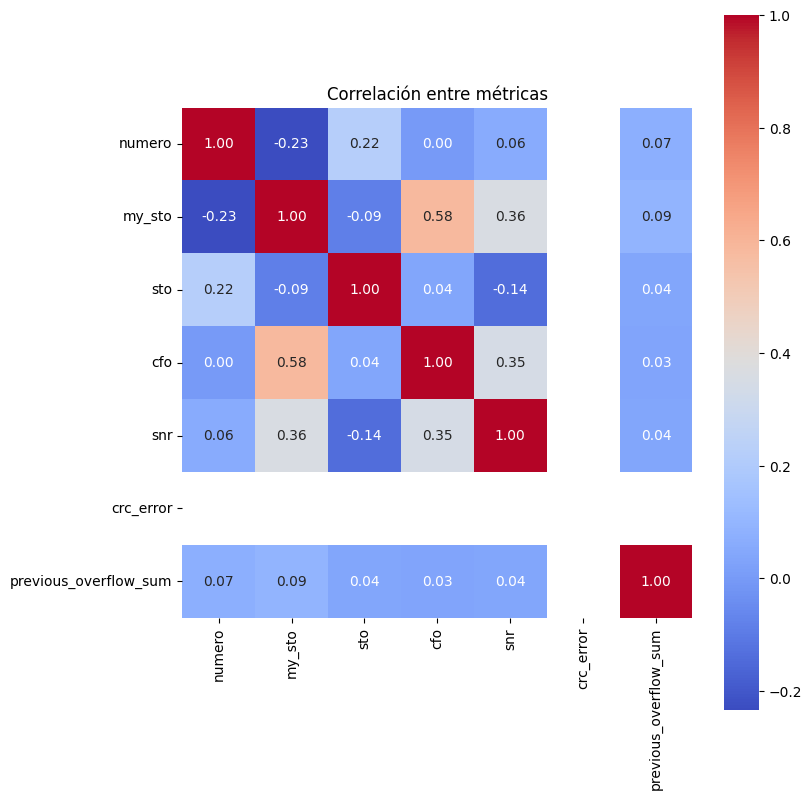

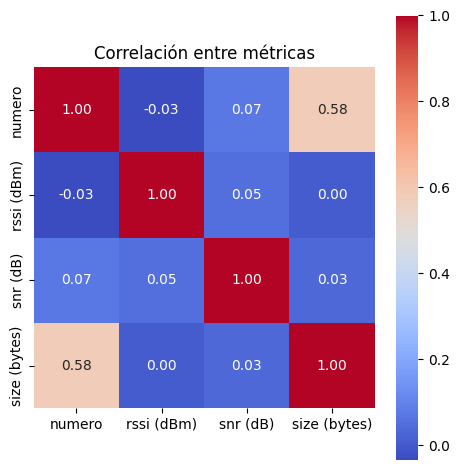

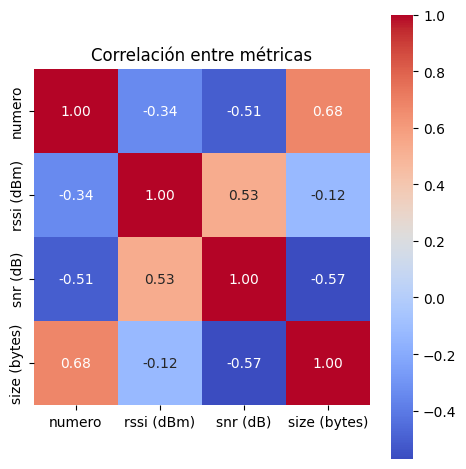

In [ ]:
plot_histograma(df_4M1M)
plot_histograma(df_8M1M)
plot_histograma(df_N_4M1M)
plot_histograma(df_N_8M1M)

plot_correlacion(df_4M1M)
plot_correlacion(df_8M1M)
plot_correlacion(df_N_4M1M)
plot_correlacion(df_N_8M1M)

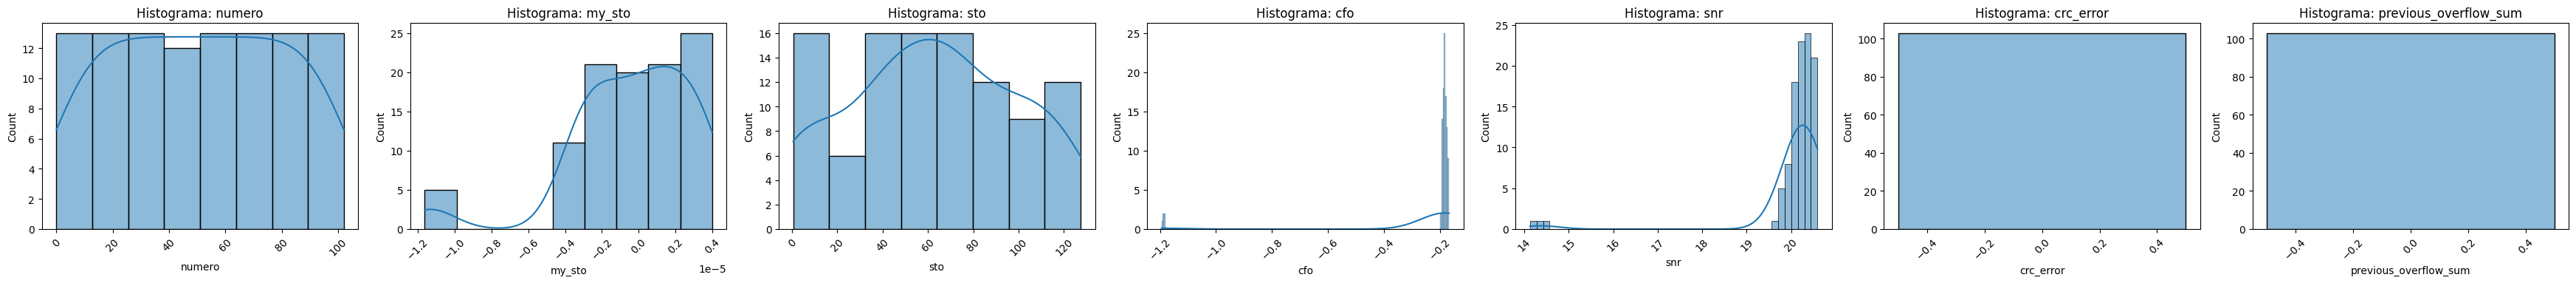

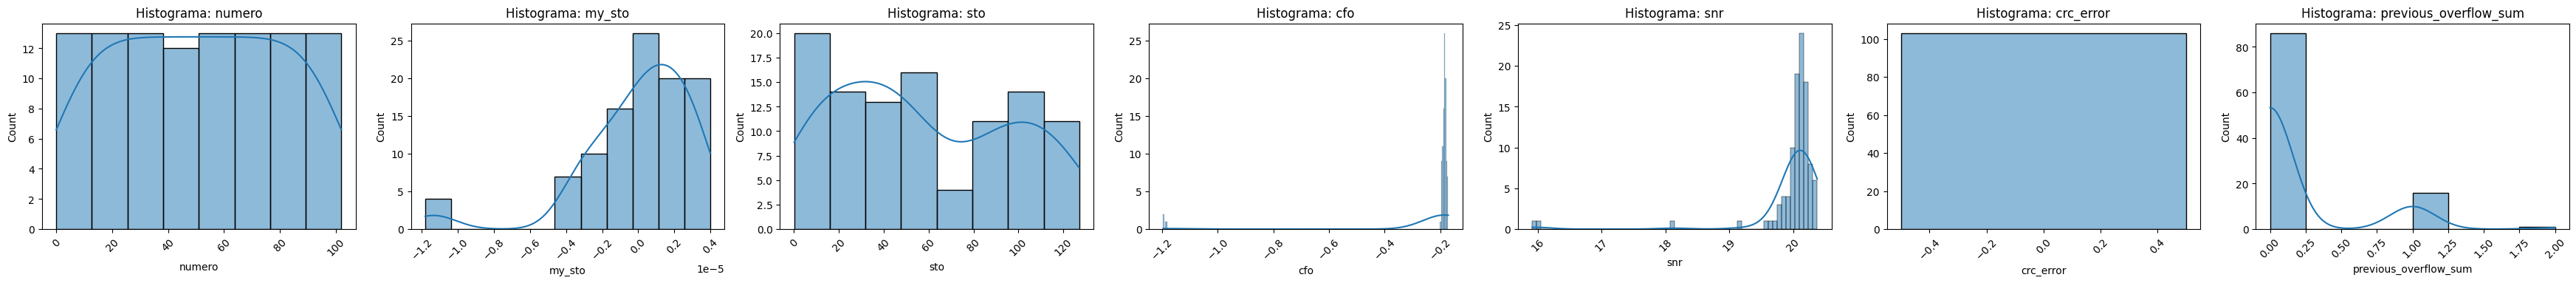

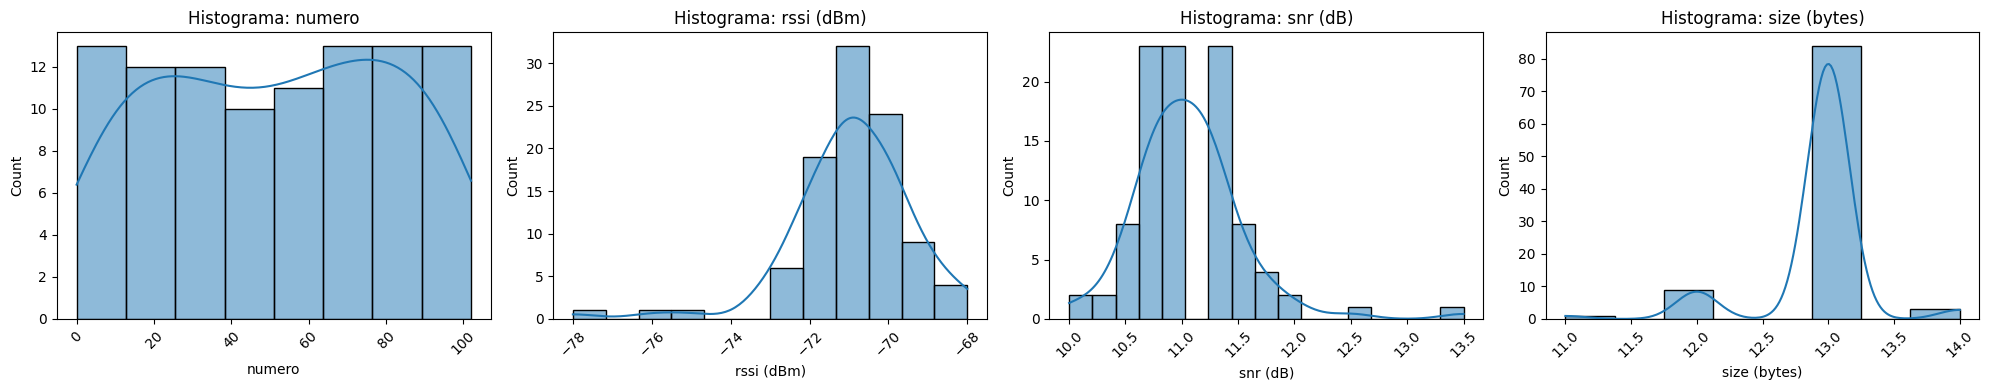

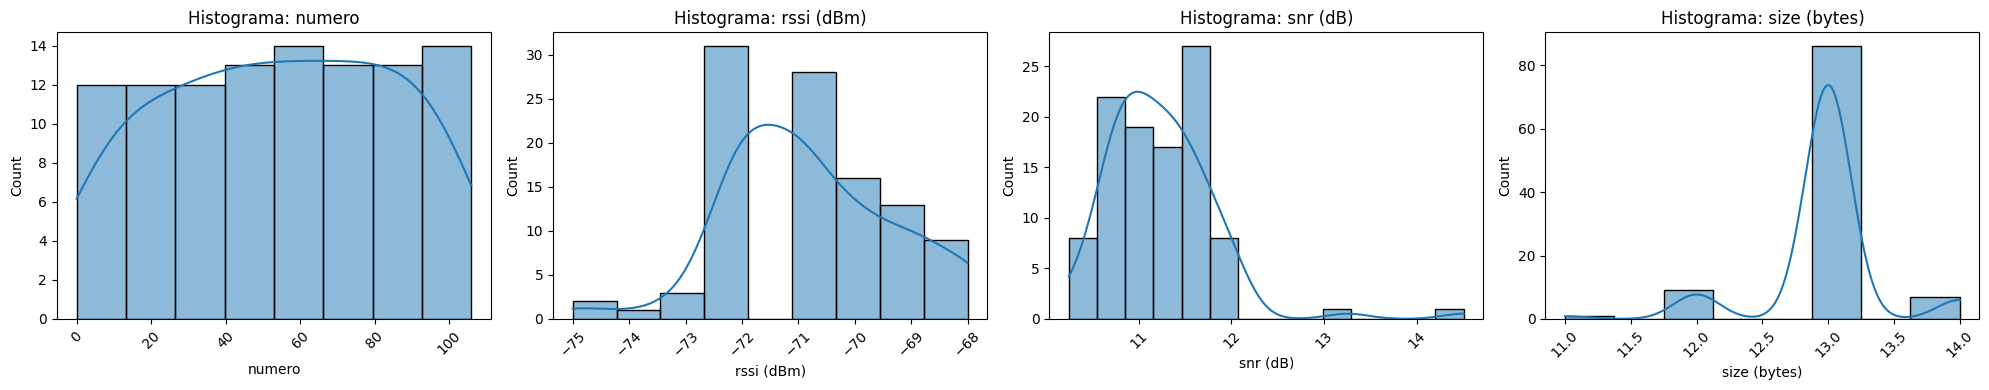

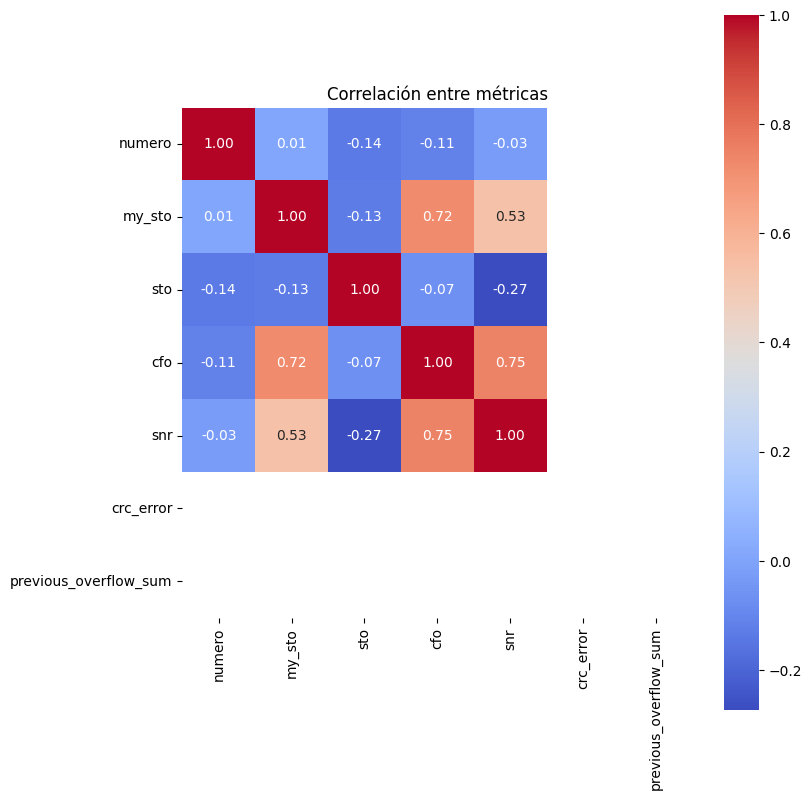

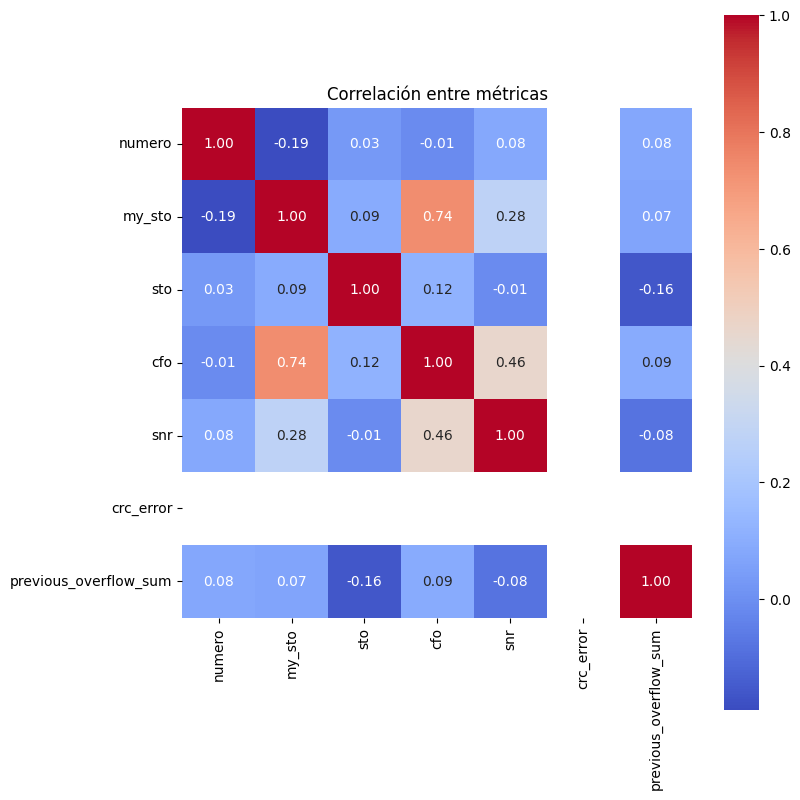

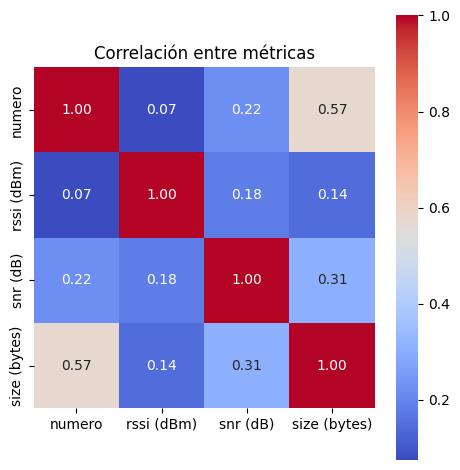

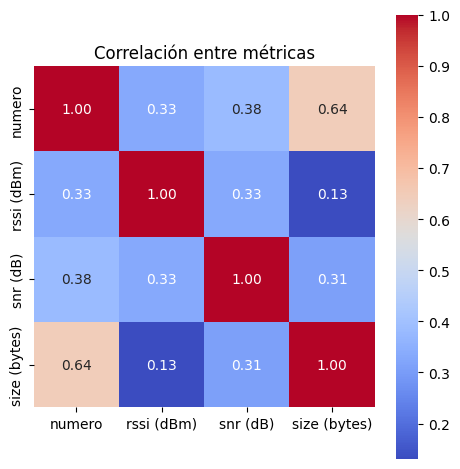

In [ ]:
plot_histograma(df_4M40M)
plot_histograma(df_8M40M)
plot_histograma(df_N_4M40M)
plot_histograma(df_N_8M40M)

plot_correlacion(df_4M40M)
plot_correlacion(df_8M40M)
plot_correlacion(df_N_4M40M)
plot_correlacion(df_N_8M40M)

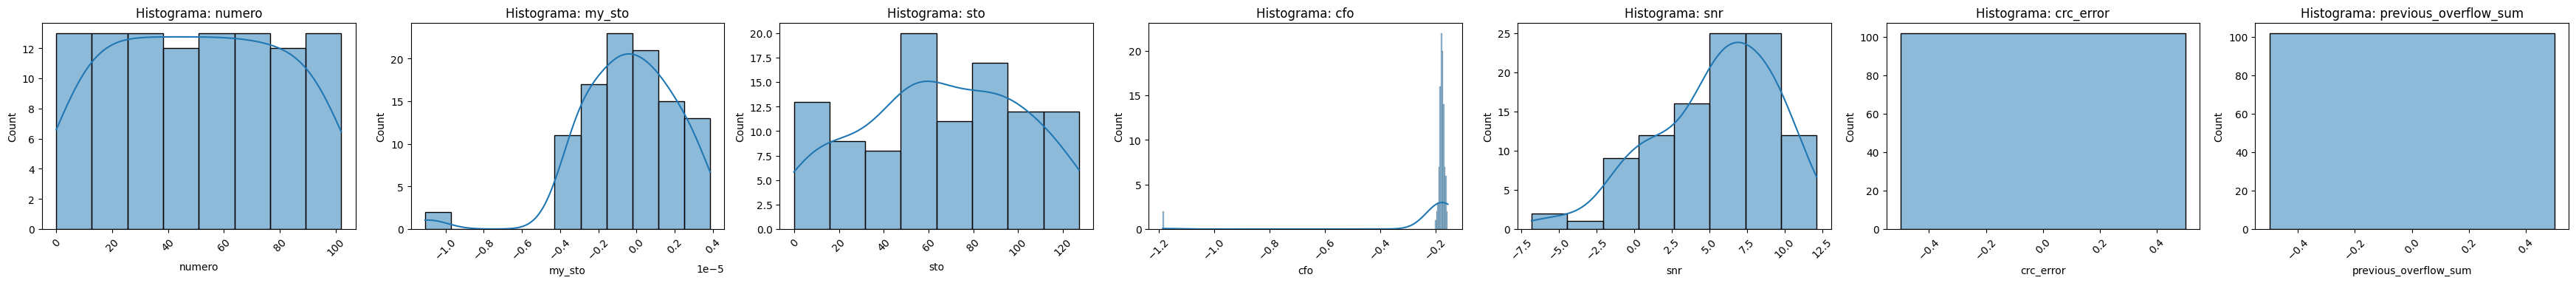

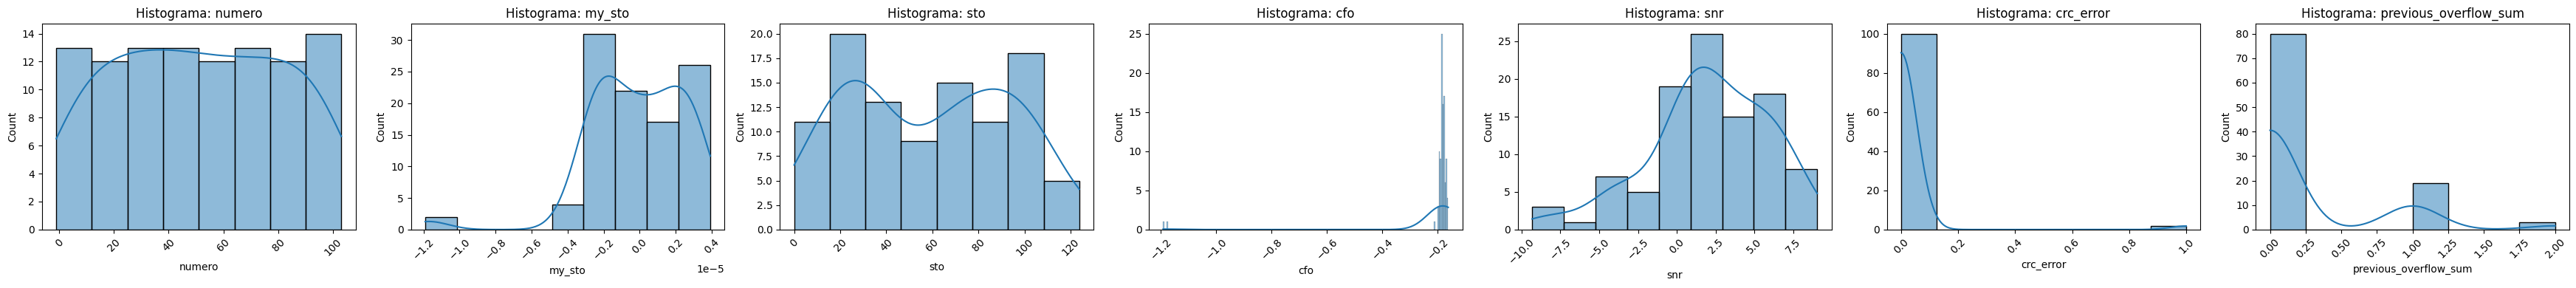

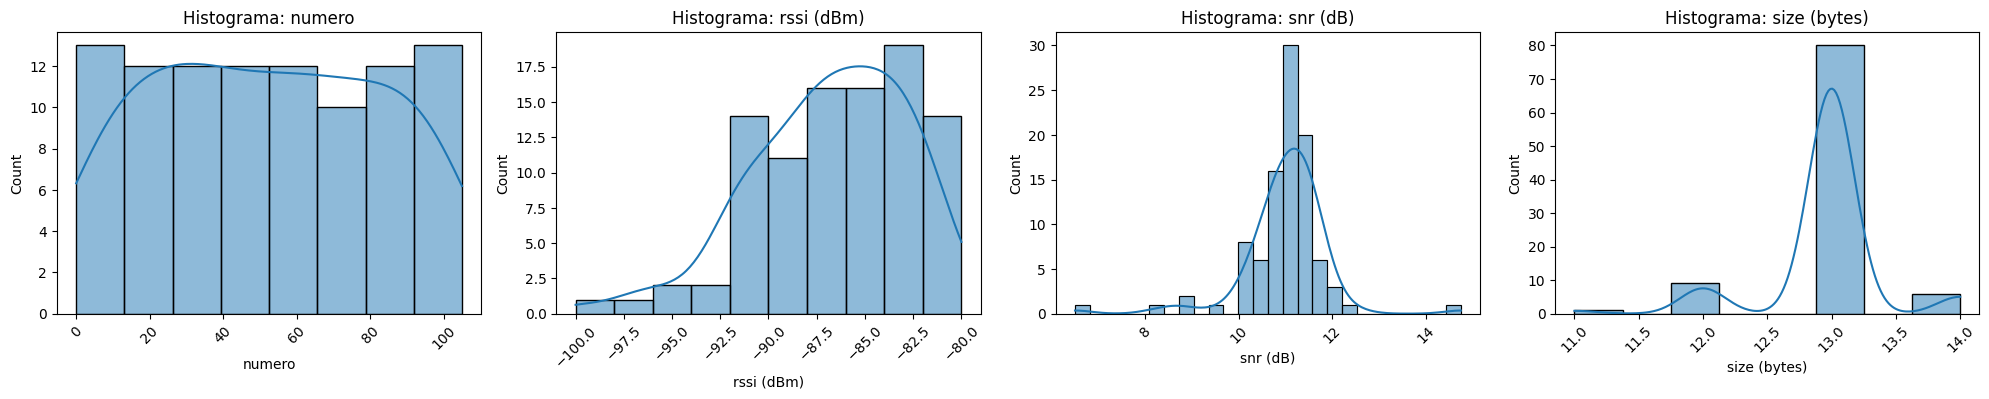

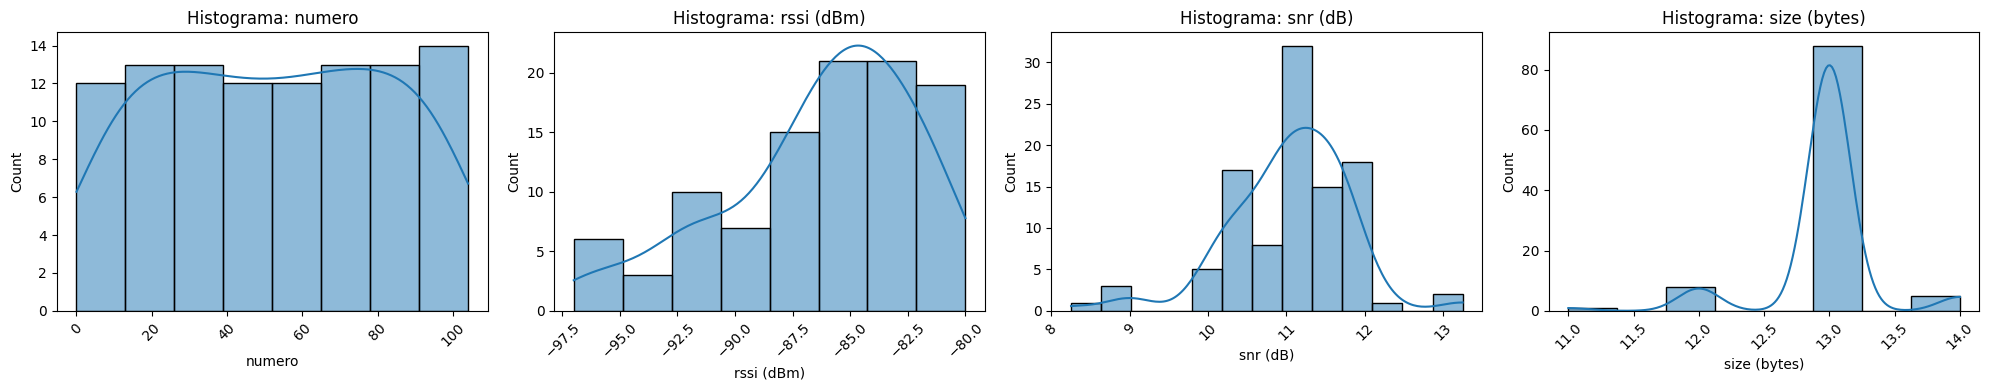

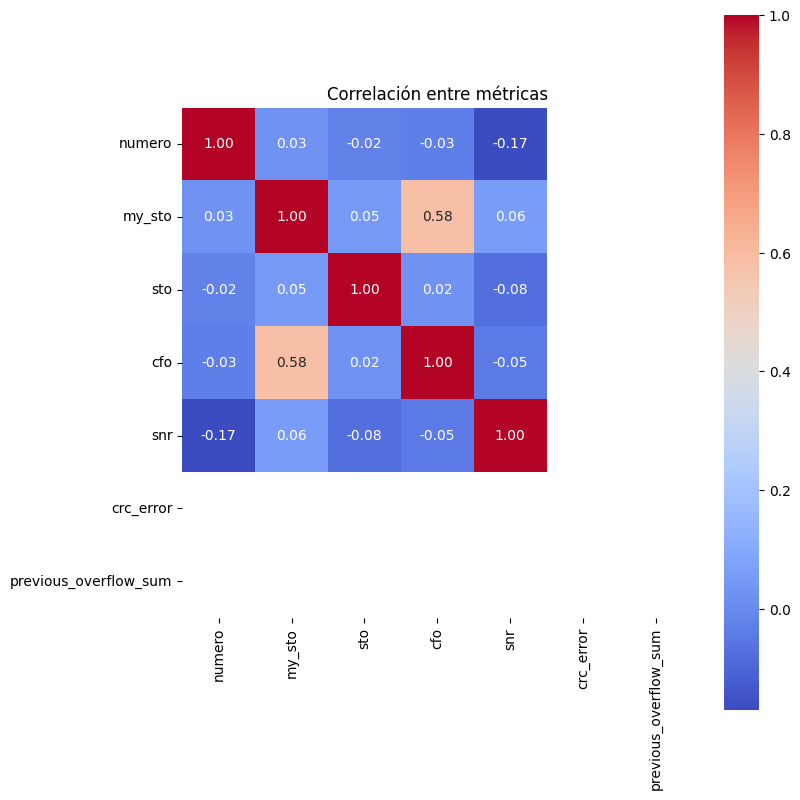

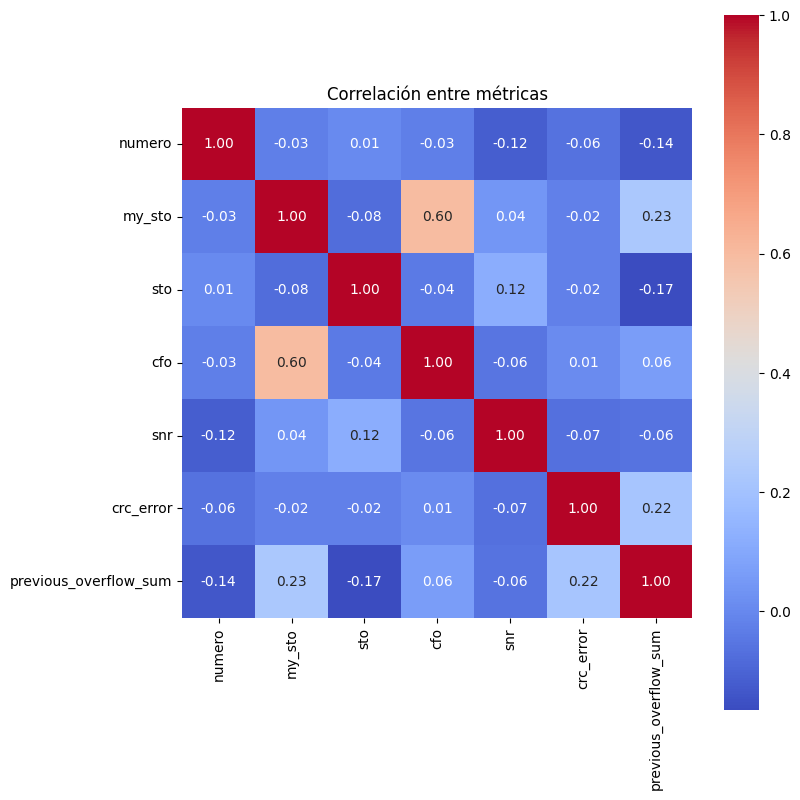

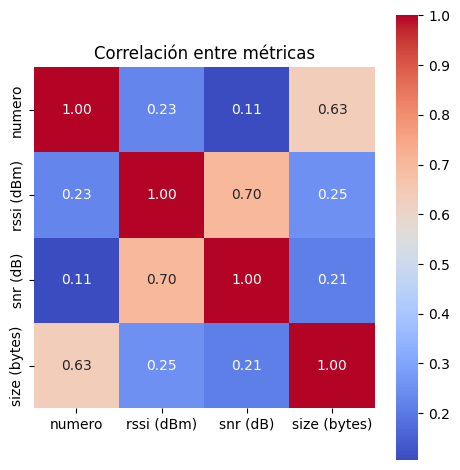

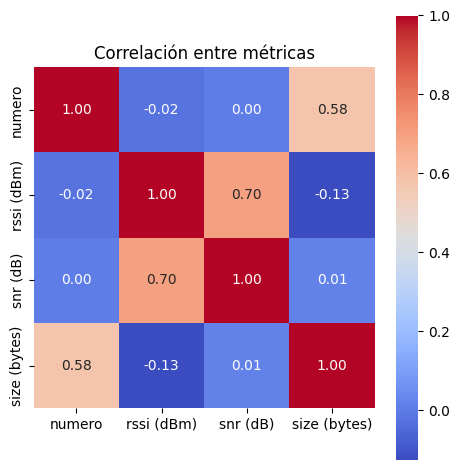

In [ ]:
plot_histograma(df_4M80M)
plot_histograma(df_8M80M)
plot_histograma(df_N_4M80M)
plot_histograma(df_N_8M80M)


plot_correlacion(df_4M80M)
plot_correlacion(df_8M80M)
plot_correlacion(df_N_4M80M)
plot_correlacion(df_N_8M80M)

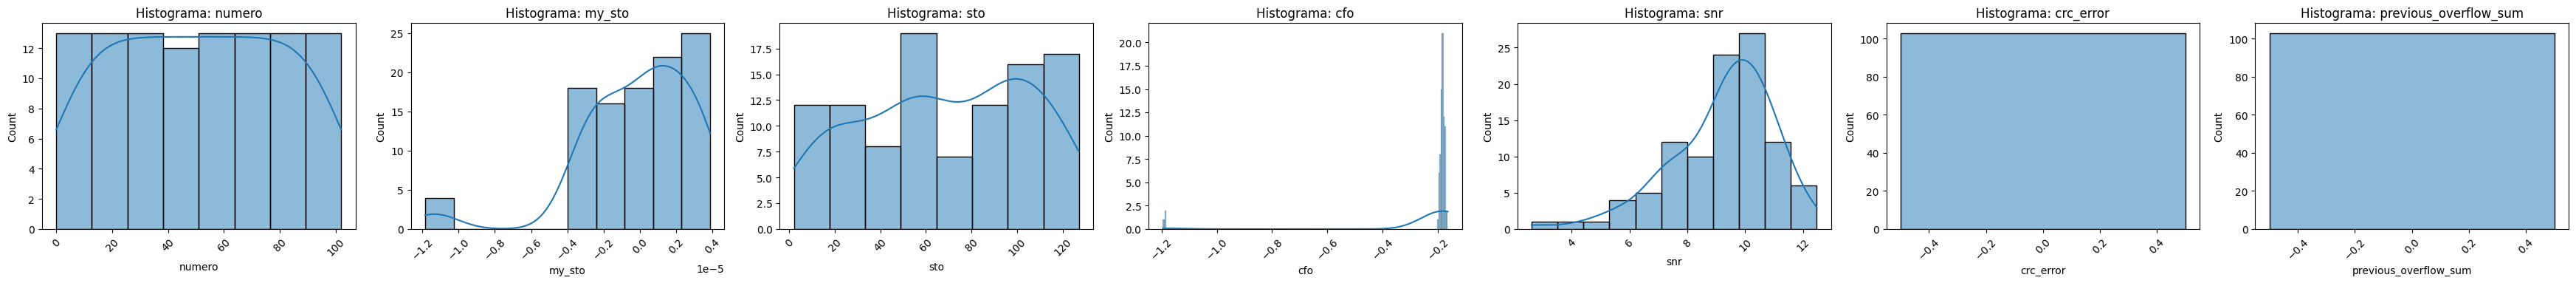

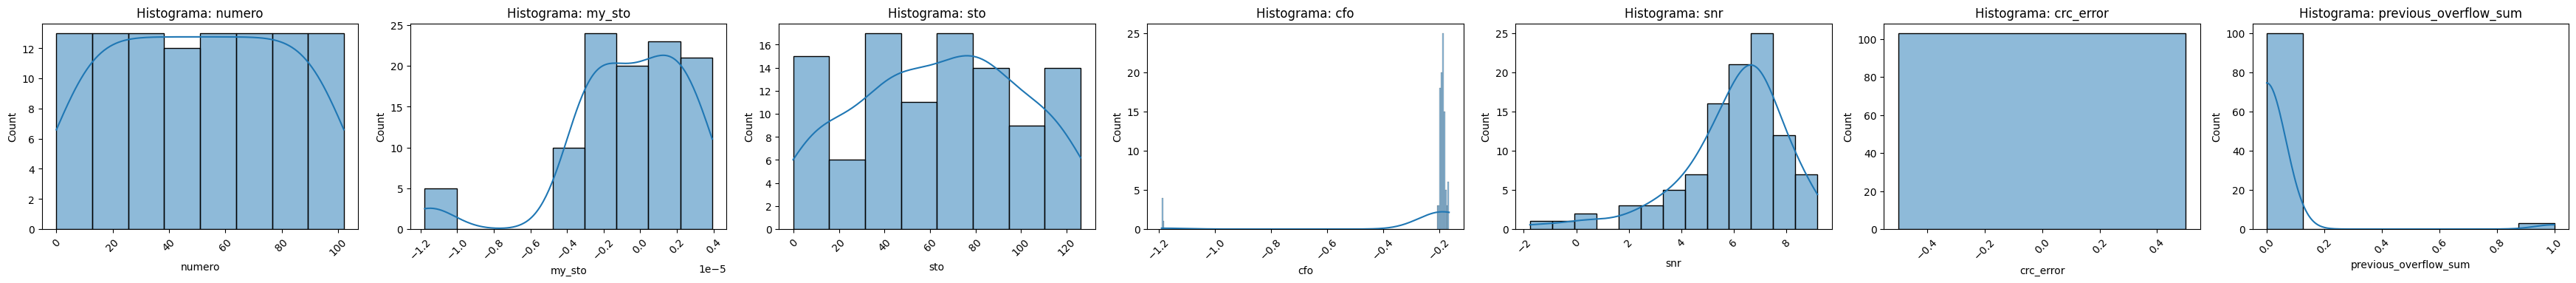

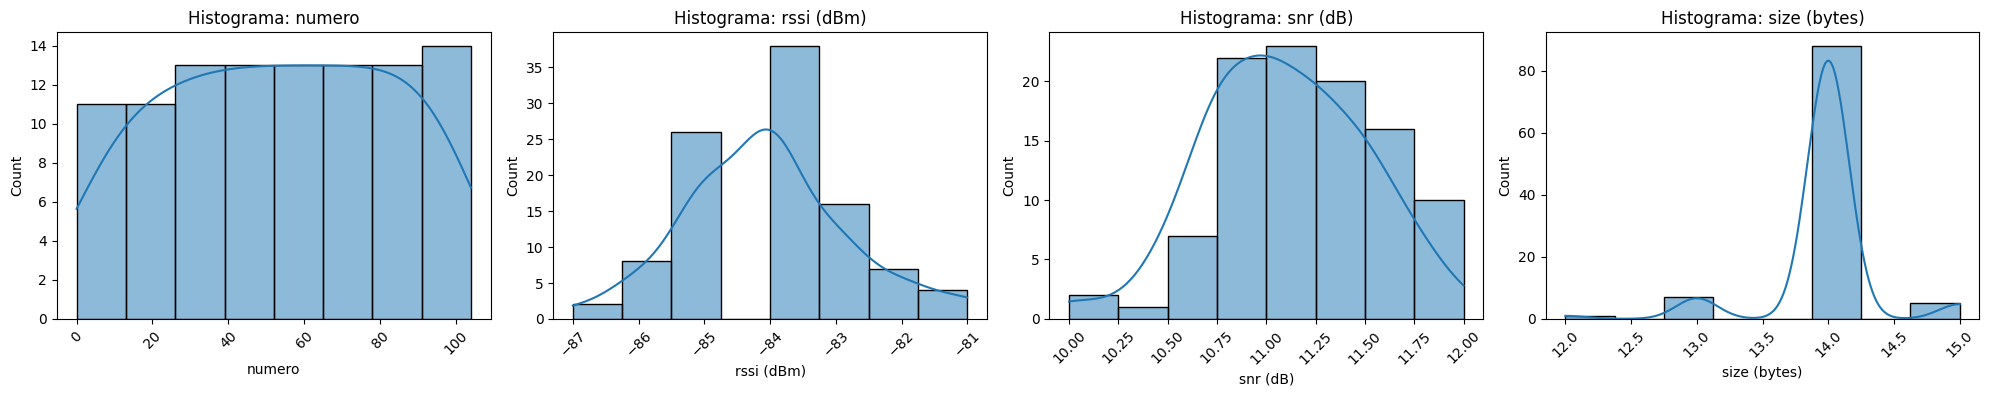

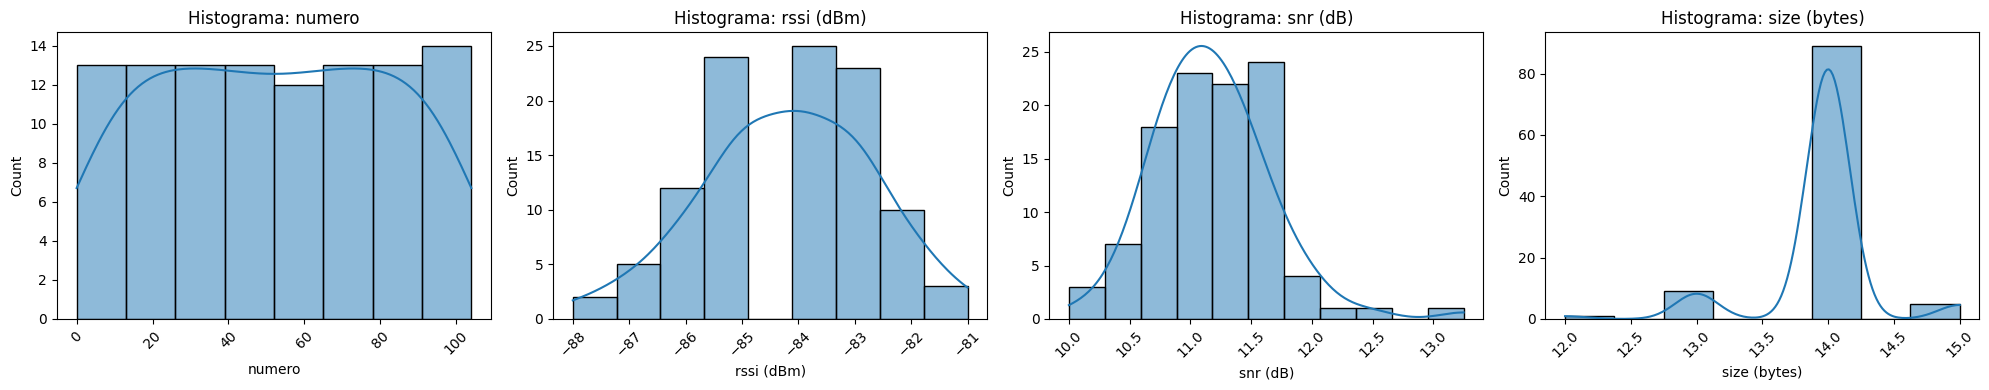

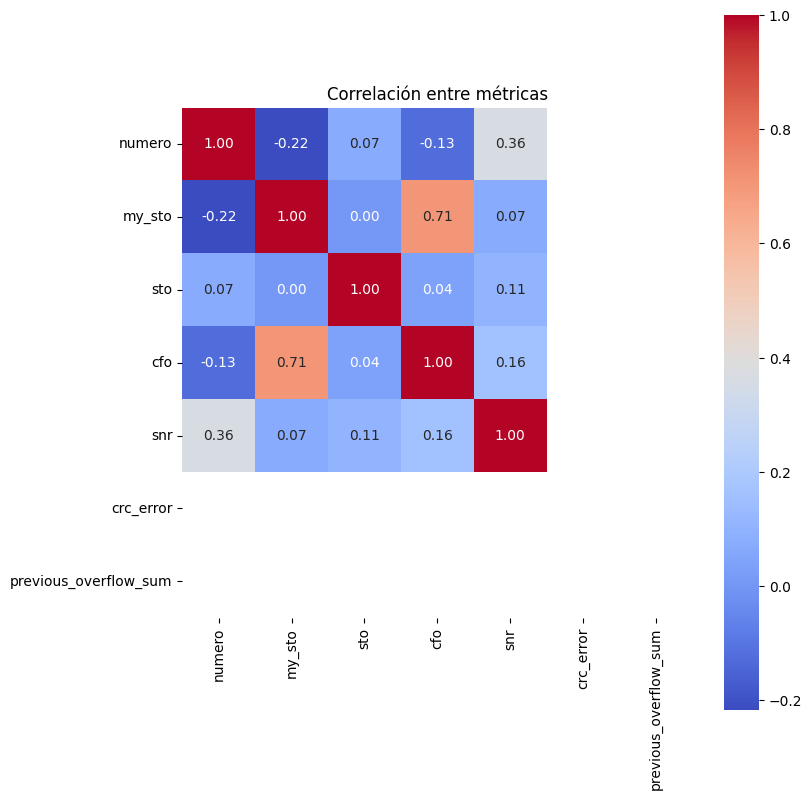

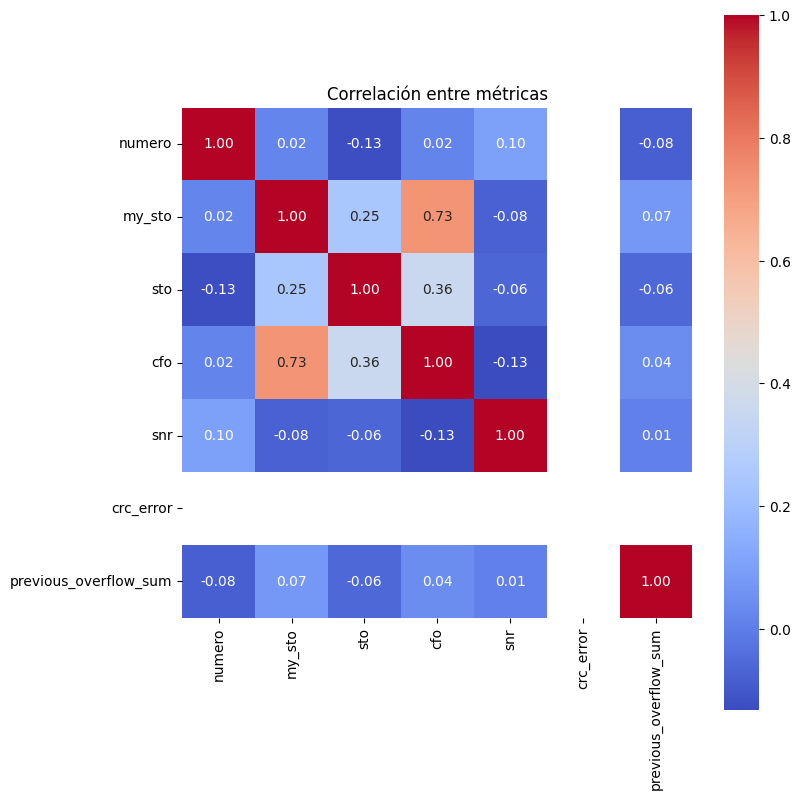

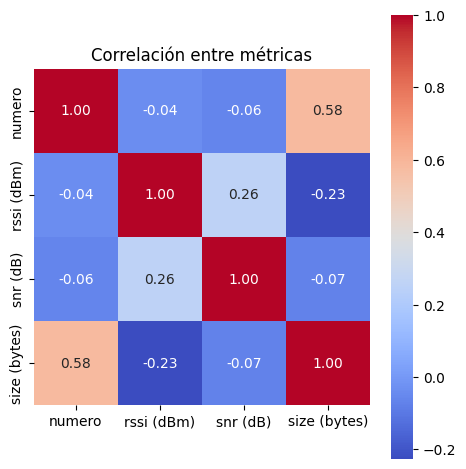

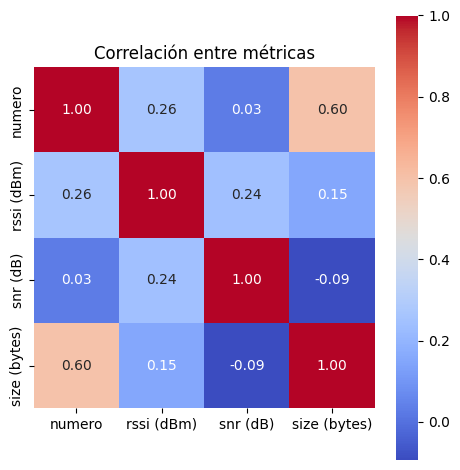

In [ ]:
plot_histograma(df_4M120M)
plot_histograma(df_8M120M)
plot_histograma(df_N_4M120M)
plot_histograma(df_N_8M120M)

plot_correlacion(df_4M120M)
plot_correlacion(df_8M120M)
plot_correlacion(df_N_4M120M)
plot_correlacion(df_N_8M120M)

### Pruebas Estadísticas

Las variables presentes en el dataset son `my_sto`, `sto`, `snr`, `cfo`, `cr_error` y `previous_overflow_sum`. El propósito de este análisis es demostrar si estas se encuentran afectadas significativamente por la distancia o no. Se realizaron pruebas Shapiro-Wilk para comprobar normalidad junto con Levene para comprobar su homocedasticidad. Dado que los datos no cumplieron estos supuestos, Anova y Anova Welch fueron descartados. Por ende, se optó por utilizar Kruskal-Wallis, adecuada para datos desbalanceados y con distribución no normal [1], [2].

[1] W. H. Kruskal and W. A. Wallis, “Use of ranks in one-criterion variance analysis,” Journal of the American Statistical Association, vol. 47, no. 260, pp. 583–621, Dec. 1952.
Disponible en: https://www.jstor.org/stable/2280779

[2] J. H. McDonald, Handbook of Biological Statistics, 3rd ed. Baltimore, MD: Sparky House Publishing, 2014. [Online]. Available: http://www.biostathandbook.com/kruskalwallis.html


In [ ]:
df_completo = pd.concat([df_4M1M, df_8M1M,
                         df_8M21M,
                         df_4M40M, df_8M40M,
                         df_8M50M,
                         df_4M80M, df_8M80M,
                         df_4M120M, df_8M120M,], ignore_index=True)

metricas = ['my_sto', 'sto', 'snr', 'cfo', 'crc_error', 'previous_overflow_sum']
resultados = []

In [ ]:
for metrica in metricas:
    if metrica in df_completo.columns:
        resultado = comparar_metricas_por_distancia(df_completo, metrica, columna_grupo='prueba')
        resultados.append(resultado)

pd.DataFrame(resultados)

C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\giuli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


,metrica,test,p-valor
0,my_sto,Kruskal-Wallis,6.080736e-01
1,sto,Kruskal-Wallis,6.996445e-02
2,snr,Kruskal-Wallis,4.343643e-190
3,cfo,Kruskal-Wallis,8.883033e-24
4,crc_error,Kruskal-Wallis,1.819007e-06
5,previous_overflow_sum,Kruskal-Wallis,4.112888e-24


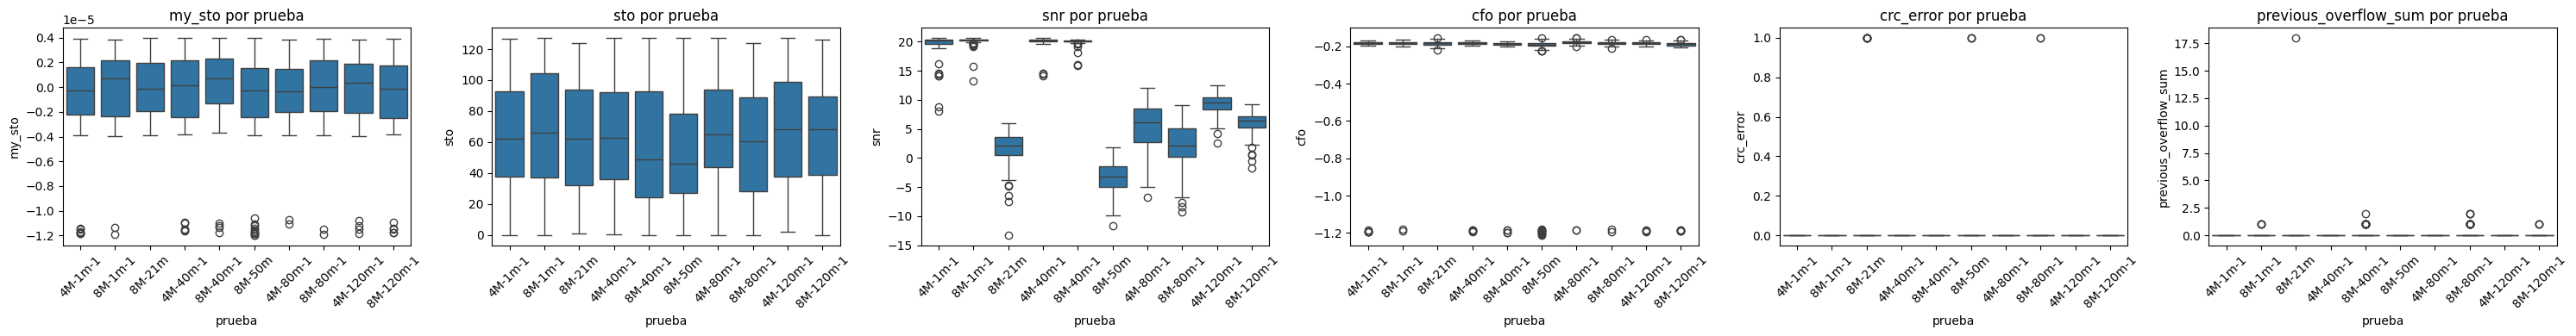

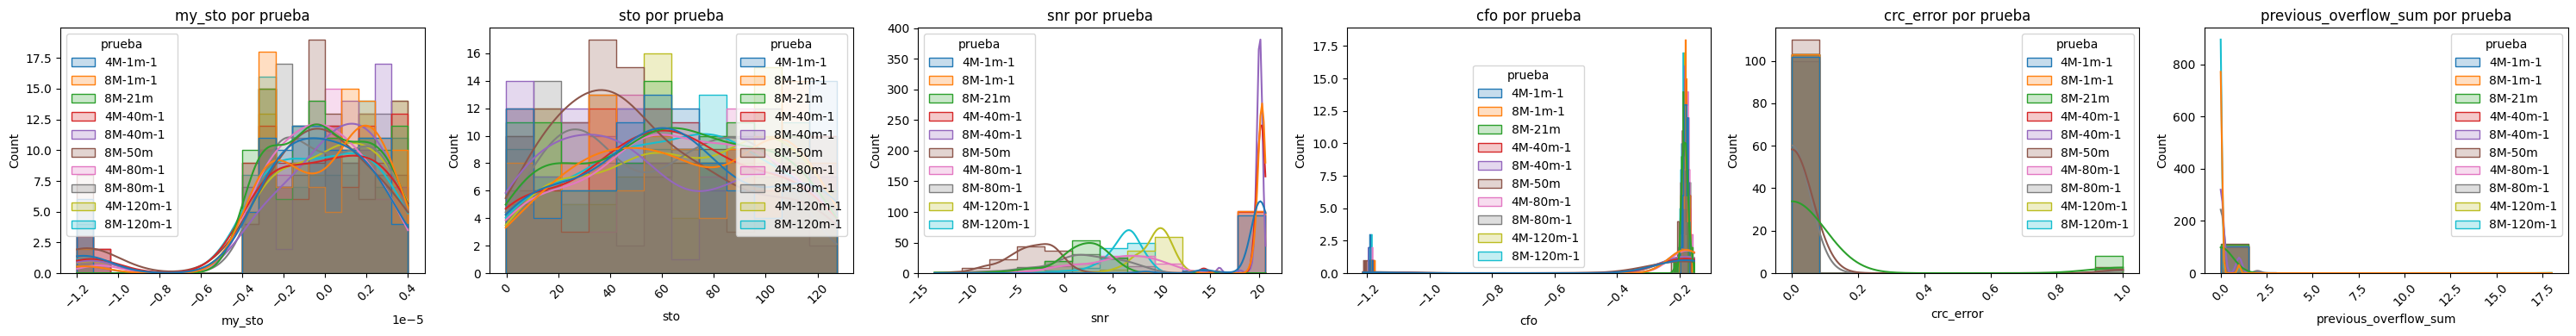

In [ ]:
plot_metricas_por_distancia(df_completo, metricas, tipo='box', columna_grupo='prueba')
plot_metricas_por_distancia(df_completo, metricas, tipo='hist', columna_grupo='prueba')

## Modelo de Propagación

In [ ]:
def extraer_distancia_inicial(prueba):
    match = re.search(r'(\d+)m(?![a-zA-Z])', prueba.lower())
    if match:
        return float(match.group(1))
    else:
        return None

In [ ]:
df_completo_N = pd.concat([df_N_4M1M, df_N_8M1M,
                         df_N_4M40M, df_N_8M40M,
                         df_N_4M80M, df_N_8M80M,
                         df_N_4M120M, df_N_8M120M,], ignore_index=True)

display(df_completo_N.head())

,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba
0,1M 4MSPS:0,0,-35,10.75,10,1m4msps
1,1M 4MSPS:01,1,-31,10.75,11,1m4msps
2,1M 4MSPS:02,2,-30,11.50,11,1m4msps
3,1M 4MSPS:03,3,-30,11.25,11,1m4msps
4,1M 4MSPS:04,4,-30,11.25,11,1m4msps


In [ ]:
df_completo_N['distancia'] = df_completo_N['prueba'].apply(extraer_distancia)
df_completo_N['distancia'] = df_completo_N['distancia'].astype(float)

display(df_completo_N.head())

,mensaje,numero,rssi (dBm),snr (dB),size (bytes),prueba,distancia
0,1M 4MSPS:0,0,-35,10.75,10,1m4msps,4.0
1,1M 4MSPS:01,1,-31,10.75,11,1m4msps,4.0
2,1M 4MSPS:02,2,-30,11.50,11,1m4msps,4.0
3,1M 4MSPS:03,3,-30,11.25,11,1m4msps,4.0
4,1M 4MSPS:04,4,-30,11.25,11,1m4msps,4.0


In [ ]:
df_modelo = df_completo_N[df_completo_N['rssi (dBm)'].notna() & df_completo_N['distancia'].notna() & (df_completo_N['distancia'] > 0)].copy()

df_modelo['log_distancia'] = np.log10(df_modelo['distancia'])

X = df_modelo[['log_distancia']]
y = df_modelo['rssi (dBm)']

modelo = LinearRegression()
modelo.fit(X, y)

LinearRegression()

In [ ]:
intercepto = modelo.intercept_
pendiente = modelo.coef_[0]
n = -pendiente / 10  # Interpretación: -10n * log10(d)

print(f"Modelo ajustado:")
print(f"   rssi (dBm) ≈ {intercepto:.2f} + ({pendiente:.2f}) * log10(distancia)")
print(f"   Pérdida (n) ≈ {n:.2f}")

Modelo ajustado:
   rssi (dBm) ≈ -56.97 + (-18.55) * log10(distancia)
   Pérdida (n) ≈ 1.85


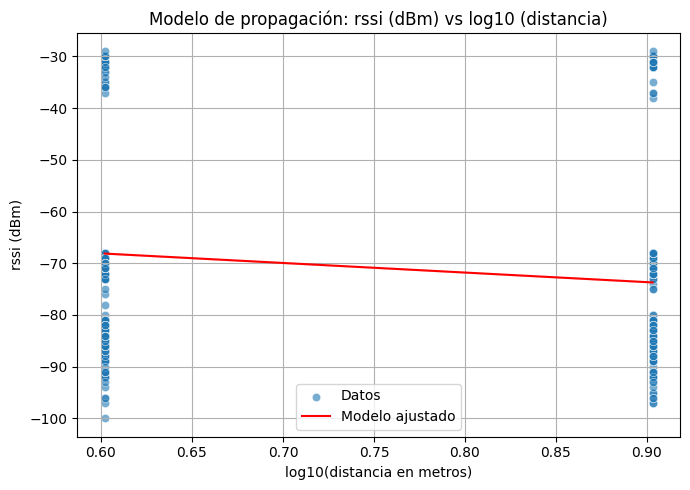

In [ ]:
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_modelo, x='log_distancia', y='rssi (dBm)', alpha=0.6, label='Datos')
sns.lineplot(x=df_modelo['log_distancia'], y=modelo.predict(X), color='red', label='Modelo ajustado')
plt.title("Modelo de propagación: rssi (dBm) vs log10 (distancia)")
plt.xlabel("log10(distancia en metros)")
plt.ylabel("rssi (dBm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()